In [5]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_curve, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
import json
pd.options.mode.chained_assignment = None   # disables warnings for chained assignments

2024-05-29 18:29:12.651760: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-29 18:29:12.652060: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-29 18:29:12.654273: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-29 18:29:12.681138: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 18:29:13.230512: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [6]:
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available: 0


In [7]:
json_path = "../protein_properties/protein_props.json"
with open(json_path) as f:
  data = json.load(f)
len(data)

20434

In [8]:
okk = pd.read_json(json_path)
properties = okk.transpose()

In [9]:
druggable_data = "../drugbank/druggable_proteins.txt"
with open(druggable_data) as f:
  druggable_proteins = [line.strip() for line in f]
print(len(druggable_proteins))

approved_drugs = "../drugbank/approved_druggable_proteins.txt"
with open(approved_drugs) as g:
  approved_proteins = [line.strip() for line in g]
print(len(approved_proteins))

3345
2652


In [10]:
glycolisation_path = "../PTMs/glycosylation.csv"
glycolisation = pd.read_csv(glycolisation_path)

ptm_path = "../PTMs/PTM_counts.csv"
ptm = pd.read_csv(ptm_path)

ppi_path = "../PPIs/ppi.json"
ppi = pd.read_json(ppi_path)
ppi = ppi.transpose()

In [11]:
domains_info = "../Domains/files_for_ml/data_top20_updated.csv"
domains = pd.read_csv(domains_info)

In [12]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20434 entries, A0A087X1C5 to Q9Y6Z2
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Sequence                      20434 non-null  object
 1   Sequence Length               20434 non-null  object
 2   Molecular Weight              20434 non-null  object
 3   GRAVY                         20434 non-null  object
 4   Amino Acid Count              20434 non-null  object
 5   Amino Acid Percent            20434 non-null  object
 6   Molar Extinction Coefficient  20434 non-null  object
 7   Isoelectric Point             20434 non-null  object
 8   Instability Index             20434 non-null  object
 9   Aromaticity                   20434 non-null  object
 10  Secondary Structure           20434 non-null  object
 11  Flexibility                   20434 non-null  object
 12  Charge at 7                   20434 non-null  object
dtypes: object(1

In [15]:
merged_df = pd.merge(ptm, glycolisation, on='Unnamed: 0')
merged_df = pd.merge(merged_df, domains, on='Unnamed: 0')
merged_df.set_index('Unnamed: 0', inplace=True)
final_df = pd.merge(merged_df, properties, left_index=True, right_index=True)
properties_df = pd.merge(final_df, ppi, left_index=True, right_index=True)

In [16]:
properties_df

,Glycosylation,Cross-link,Modified residue,Signal,Disulfide bond,O-linked,N-linked,C-linked,N-beta-linked,S-linked,...,Isoelectric Point,Instability Index,Aromaticity,Secondary Structure,Flexibility,Charge at 7,binary_count,binary_experimental_count,xeno_count,xeno_experimental_count
A0A087X1C5,1,0,0,0,0,0,1,0,0,0,...,8.703506,45.155922,0.085437,"[0.31456310679611604, 0.262135922330097, 0.378...","[0.977440476190476, 0.9806071428571421, 0.9983...",5.889114,0,0,0,0
A0A0B4J2F0,0,0,0,0,0,0,0,0,0,0,...,8.03542,55.518519,0.12963,"[0.44444444444444403, 0.129629629629629, 0.388...","[0.982095238095238, 0.95625, 0.983214285714285...",0.510326,1,11,0,0
A0A0B4J2F2,0,0,0,0,0,0,0,0,0,0,...,6.813029,59.277803,0.063857,"[0.314176245210727, 0.31289910600255405, 0.328...","[1.00125, 0.970071428571428, 1.034523809523809...",-1.004586,6,18,0,0
A0A0C5B5G6,0,0,0,0,0,0,0,0,0,0,...,10.266413,77.300625,0.25,"[0.3125, 0.125, 0.375]","[0.9704047619047621, 1.00345238095238, 0.95860...",2.500138,0,0,0,0
A0A0K2S4Q6,1,0,0,1,1,0,1,0,0,0,...,5.366988,41.796517,0.074627,"[0.283582089552238, 0.308457711442786, 0.40298...","[1.008285714285714, 0.9868928571428571, 0.991,...",-3.378625,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9UI54,0,0,0,0,0,0,0,0,0,0,...,10.302902,35.789091,0.145455,"[0.29090909090909, 0.218181818181818, 0.527272...","[0.9746904761904761, 1.00325, 0.98202380952380...",7.571427,0,0,0,0
Q9UI72,0,0,0,0,0,0,0,0,0,0,...,9.348383,46.171014,0.101449,"[0.30434782608695604, 0.24637681159420202, 0.2...","[1.006333333333333, 0.9435238095238091, 0.9573...",3.659009,0,0,0,0
Q9Y3F1,0,0,0,0,0,0,0,0,0,0,...,4.493088,69.675,0.196429,"[0.30357142857142805, 0.232142857142857, 0.535...","[0.988154761904761, 0.9863214285714281, 0.9781...",-2.5132,0,0,0,0
Q9Y6C7,0,0,0,0,0,0,0,0,0,0,...,10.192468,62.375638,0.117021,"[0.319148936170212, 0.24468085106382903, 0.436...","[0.9616666666666661, 1.001988095238095, 0.9683...",6.176832,0,0,0,0


In [17]:
properties_df.dropna(inplace = True)
properties_df.isna().sum()

Glycosylation                   0
Cross-link                      0
Modified residue                0
Signal                          0
Disulfide bond                  0
O-linked                        0
N-linked                        0
C-linked                        0
N-beta-linked                   0
S-linked                        0
O-alpha-linked                  0
rrm                             0
acidic residues                 0
ph                              0
krab                            0
pdz                             0
btb                             0
nuclear localization signal     0
fibronectin type-iii            0
disordered                      0
ig-like v-type                  0
ef-hand                         0
sh3                             0
ig-like                         0
pro residues                    0
protein kinase                  0
ig-like c2-type                 0
basic and acidic residues       0
basic residues                  0
egf-like      

In [18]:
is_druggable = []
for i in properties_df.index:
  if i in druggable_proteins:
    is_druggable.append(1)
  else:
    is_druggable.append(0)

approved_drugs = []
for j in properties_df.index:
  if j in approved_proteins:
    approved_drugs.append(1)
  else:
    approved_drugs.append(0)

properties_df['is_druggable'] = is_druggable
properties_df['is_approved'] = approved_drugs
properties_df

,Glycosylation,Cross-link,Modified residue,Signal,Disulfide bond,O-linked,N-linked,C-linked,N-beta-linked,S-linked,...,Aromaticity,Secondary Structure,Flexibility,Charge at 7,binary_count,binary_experimental_count,xeno_count,xeno_experimental_count,is_druggable,is_approved
A0A087X1C5,1,0,0,0,0,0,1,0,0,0,...,0.085437,"[0.31456310679611604, 0.262135922330097, 0.378...","[0.977440476190476, 0.9806071428571421, 0.9983...",5.889114,0,0,0,0,0,0
A0A0B4J2F0,0,0,0,0,0,0,0,0,0,0,...,0.12963,"[0.44444444444444403, 0.129629629629629, 0.388...","[0.982095238095238, 0.95625, 0.983214285714285...",0.510326,1,11,0,0,0,0
A0A0B4J2F2,0,0,0,0,0,0,0,0,0,0,...,0.063857,"[0.314176245210727, 0.31289910600255405, 0.328...","[1.00125, 0.970071428571428, 1.034523809523809...",-1.004586,6,18,0,0,0,0
A0A0C5B5G6,0,0,0,0,0,0,0,0,0,0,...,0.25,"[0.3125, 0.125, 0.375]","[0.9704047619047621, 1.00345238095238, 0.95860...",2.500138,0,0,0,0,0,0
A0A0K2S4Q6,1,0,0,1,1,0,1,0,0,0,...,0.074627,"[0.283582089552238, 0.308457711442786, 0.40298...","[1.008285714285714, 0.9868928571428571, 0.991,...",-3.378625,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9UI54,0,0,0,0,0,0,0,0,0,0,...,0.145455,"[0.29090909090909, 0.218181818181818, 0.527272...","[0.9746904761904761, 1.00325, 0.98202380952380...",7.571427,0,0,0,0,0,0
Q9UI72,0,0,0,0,0,0,0,0,0,0,...,0.101449,"[0.30434782608695604, 0.24637681159420202, 0.2...","[1.006333333333333, 0.9435238095238091, 0.9573...",3.659009,0,0,0,0,0,0
Q9Y3F1,0,0,0,0,0,0,0,0,0,0,...,0.196429,"[0.30357142857142805, 0.232142857142857, 0.535...","[0.988154761904761, 0.9863214285714281, 0.9781...",-2.5132,0,0,0,0,0,0
Q9Y6C7,0,0,0,0,0,0,0,0,0,0,...,0.117021,"[0.319148936170212, 0.24468085106382903, 0.436...","[0.9616666666666661, 1.001988095238095, 0.9683...",6.176832,0,0,0,0,0,0


In [19]:
def test_results(y_pred, y_test):
    results = {}
    results['Accuracy'] = accuracy_score(y_test,y_pred)
    results['Precision'] = precision_score(y_test,y_pred,average = 'weighted')
    results['Recall'] = recall_score(y_test,y_pred,average = 'weighted')
    results['F1_Score'] = f1_score(y_test,y_pred,average = 'weighted')
    results['ROC_AUC'] = roc_auc_score(y_test, y_pred)

    cm = confusion_matrix(y_test,y_pred)
    return results, cm

In [20]:
# Load the dictionary from the JSON file
location_path = "../SCL/subcellular_locations2.json"
with open(location_path, 'r') as file:
    data = json.load(file)

unique_groups = set()

for entry in data.values():
    if "general" in entry:
        for general_entry in entry["general"]:
            if "group" in general_entry:
                unique_groups.add(general_entry["group"])

unique_groups_list = list(unique_groups)

print(unique_groups_list)

['golgo apparatus', 'cell membrane', 'endoplasmic reticulum', 'dynein axonemal particle', 'golgi outpost', 'cytolitic granule', 'recycling endosome', 'cell projection', 'postsynapse', 'myelin membrane', 'endosome', 'cytoplasmic granule', 'target cell membrane', 'parasitophorous vacuole', 'perikaryon', 'lateral cell membrane', 'rough endoplasmic reticulum', 'nucleus', 'vacuole', 'extracellular vessicle', 'virion', 'peroxisome', 'smooth endoplasmic reticulum membrane', 'vesicle', 'zymogen granule', 'cytoplasm', 'late endosome', 'chromosome', 'sarcoplasmic reticulum', 'lipid droplet', 'photoreceptor', 'midbody', 'mitochondrion', 'cornified envelope', 'endomembrane system', 'secreted', 'early endosome', 'melanosome', 'cytoplasmic vesicle', 'vacuole membrane', 'inflammasome', 'cell junction', 'membrane', 'presynapse', 'cell surface', 'lysosome', 'cleavage furrow', 'preautophagosomal structure', 'microsome', 'synapse']


In [21]:
len(unique_groups_list)

50

In [22]:
for group in unique_groups_list:
    properties_df[group] = 0

    for protein_id in properties_df.index:
        if protein_id in data:
            for entry in data[protein_id].get("general", []):
                if "group" in entry and entry["group"] == group:
                    properties_df.at[protein_id, group] = 1

In [23]:
properties_df.columns

Index(['Glycosylation', 'Cross-link', 'Modified residue', 'Signal',
       'Disulfide bond', 'O-linked', 'N-linked', 'C-linked', 'N-beta-linked',
       'S-linked', 'O-alpha-linked', 'rrm', 'acidic residues', 'ph', 'krab',
       'pdz', 'btb', 'nuclear localization signal', 'fibronectin type-iii',
       'disordered', 'ig-like v-type', 'ef-hand', 'sh3', 'ig-like',
       'pro residues', 'protein kinase', 'ig-like c2-type',
       'basic and acidic residues', 'basic residues', 'egf-like',
       'polar residues', 'Sequence', 'Sequence Length', 'Molecular Weight',
       'GRAVY', 'Amino Acid Count', 'Amino Acid Percent',
       'Molar Extinction Coefficient', 'Isoelectric Point',
       'Instability Index', 'Aromaticity', 'Secondary Structure',
       'Flexibility', 'Charge at 7', 'binary_count',
       'binary_experimental_count', 'xeno_count', 'xeno_experimental_count',
       'is_druggable', 'is_approved', 'golgo apparatus', 'cell membrane',
       'endoplasmic reticulum', 'dynein axo

In [24]:
properties_df

,Glycosylation,Cross-link,Modified residue,Signal,Disulfide bond,O-linked,N-linked,C-linked,N-beta-linked,S-linked,...,inflammasome,cell junction,membrane,presynapse,cell surface,lysosome,cleavage furrow,preautophagosomal structure,microsome,synapse
A0A087X1C5,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
A0A0B4J2F0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0A0B4J2F2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0A0C5B5G6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0A0K2S4Q6,1,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9UI54,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Q9UI72,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Q9Y3F1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Q9Y6C7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
index = 'A C D E F G H I K L M N P Q R S T V W Y'
for i in index.split(" "):
  properties_df[f"Amino_Acid_{i}_Percent"] = pd.Series([0]*properties_df.shape[0])
properties_df['Molar Extinction Coefficient 1'] = pd.Series([0]*properties_df.shape[0])
properties_df['Molar Extinction Coefficient 2'] = pd.Series([0]*properties_df.shape[0])
properties_df['Secondary Structure helix'] = pd.Series([0]*properties_df.shape[0])
properties_df['Secondary Structure turn'] = pd.Series([0]*properties_df.shape[0])
properties_df['Secondary Structure sheet'] = pd.Series([0]*properties_df.shape[0])
for i in range(properties_df.shape[0]):
  for j,k in properties_df['Amino Acid Percent'][i].items():
    properties_df[f"Amino_Acid_{j}_Percent"][i] = k
  properties_df['Molar Extinction Coefficient 1'][i] = properties_df['Molar Extinction Coefficient'][i][0]
  properties_df['Molar Extinction Coefficient 2'][i] = properties_df['Molar Extinction Coefficient'][i][1]
  properties_df['Secondary Structure helix'][i] = properties_df['Secondary Structure'][i][0]
  properties_df['Secondary Structure turn'][i] = properties_df['Secondary Structure'][i][1]
  properties_df['Secondary Structure sheet'][i] = properties_df['Secondary Structure'][i][2]
properties_df.drop(columns = ['Sequence','Sequence Length','Amino Acid Count','Amino Acid Percent','Molar Extinction Coefficient','Secondary Structure'],axis = 1, inplace = True)

In [26]:
# Dropping flexibility because we dont need it

data = properties_df.drop(['Flexibility'],axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20434 entries, A0A087X1C5 to Q9Y6Z2
Columns: 118 entries, Glycosylation to Secondary Structure sheet
dtypes: float64(25), int64(87), object(6)
memory usage: 19.1+ MB


In [27]:
data

,Glycosylation,Cross-link,Modified residue,Signal,Disulfide bond,O-linked,N-linked,C-linked,N-beta-linked,S-linked,...,Amino_Acid_S_Percent,Amino_Acid_T_Percent,Amino_Acid_V_Percent,Amino_Acid_W_Percent,Amino_Acid_Y_Percent,Molar Extinction Coefficient 1,Molar Extinction Coefficient 2,Secondary Structure helix,Secondary Structure turn,Secondary Structure sheet
A0A087X1C5,1,0,0,0,0,0,1,0,0,0,...,0.048544,0.048544,0.085437,0.013592,0.011650,47440.0,47940.0,0.314563,0.262136,0.378641
A0A0B4J2F0,0,0,0,0,0,0,0,0,0,0,...,0.037037,0.037037,0.074074,0.000000,0.037037,2980.0,2980.0,0.444444,0.129630,0.388889
A0A0B4J2F2,0,0,0,0,0,0,0,0,0,0,...,0.085568,0.052363,0.053640,0.007663,0.020434,56840.0,57965.0,0.314176,0.312899,0.328225
A0A0C5B5G6,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.062500,0.125000,8480.0,8480.0,0.312500,0.125000,0.375000
A0A0K2S4Q6,1,0,0,1,1,0,1,0,0,0,...,0.099502,0.084577,0.079602,0.024876,0.019900,33460.0,33960.0,0.283582,0.308458,0.402985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9UI54,0,0,0,0,0,0,0,0,0,0,...,0.109091,0.109091,0.054545,0.000000,0.036364,2980.0,2980.0,0.290909,0.218182,0.527273
Q9UI72,0,0,0,0,0,0,0,0,0,0,...,0.028986,0.043478,0.014493,0.028986,0.043478,15470.0,15595.0,0.304348,0.246377,0.275362
Q9Y3F1,0,0,0,0,0,0,0,0,0,0,...,0.142857,0.107143,0.017857,0.035714,0.053571,15470.0,15595.0,0.303571,0.232143,0.535714
Q9Y6C7,0,0,0,0,0,0,0,0,0,0,...,0.085106,0.063830,0.031915,0.042553,0.021277,24980.0,25105.0,0.319149,0.244681,0.436170


In [28]:
data.isna().sum().sum()

0

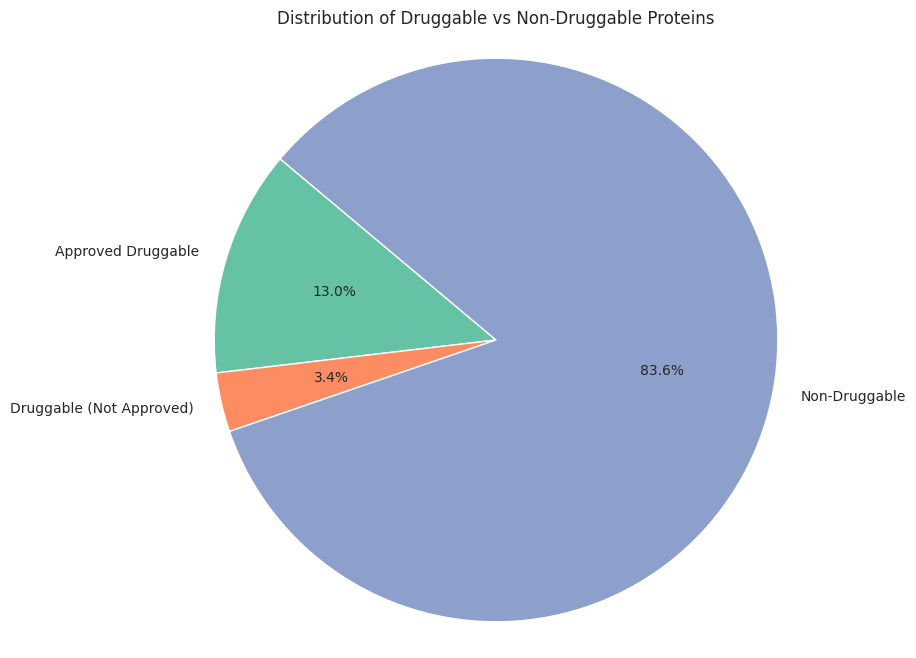

In [29]:
druggable_counts = properties_df['is_druggable'].value_counts()

druggable_df = properties_df[properties_df['is_druggable'] == 1]
approved_druggable_count = druggable_df['is_approved'].sum()

total_proteins = properties_df.shape[0]

non_druggable_count = total_proteins - druggable_counts[1]
non_approved_druggable_count = druggable_counts[1] - approved_druggable_count

# Plotting
plt.figure(figsize=(8, 8))
plt.pie([approved_druggable_count, non_approved_druggable_count, non_druggable_count], labels=['Approved Druggable', 'Druggable (Not Approved)', 'Non-Druggable'], autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62', '#8da0cb'])
plt.title('Distribution of Druggable vs Non-Druggable Proteins')
plt.axis('equal')
plt.show()

In [33]:
# fig,ax = plt.subplots(figsize = (50,80),nrows = 23,ncols = 2)
okk = [i for i in data.columns if i!= "is_druggable" and i!= "is_approved" and i not in unique_groups_list]
# for i,values in enumerate(okk):
#   if i <23:
#     sns.kdeplot(data=data[data['is_druggable'] == 1], x=values, ax=ax[i][0],alpha = 0.7,common_norm = True, label = 'druggable')
#     sns.kdeplot(data = data[data['is_druggable'] == 0], x=values, ax=ax[i][0],alpha = 0.7,common_norm = True, label ='not_druggable')
#     ax[i][0].axvline(data[values].mean(), color='red', linestyle='dashed', linewidth=2)
#     ax[i][0].set_title(values)
#     ax[i][0].legend()
#   else:
#     sns.kdeplot(data=data[data['is_druggable'] == 1], x=values, ax=ax[i-23][1],alpha = 0.7,common_norm = True,label = 'druggable')
#     sns.kdeplot(data=data[data['is_druggable'] == 0], x=values, ax=ax[i-23][1],alpha = 0.7,common_norm = True,label ='not_druggable')
#     ax[i-23][1].axvline(data[values].mean(), color='red', linestyle='dashed', linewidth=2)
#     ax[i-23][1].set_title(values)
#     ax[i-23][1].legend()

# plt.tight_layout()
# plt.show()

In [32]:
# fig,ax = plt.subplots(figsize = (20,50), nrows = 46 )
# for i,values in enumerate(okk):
#   sns.boxplot(data[values], orient = 'h',ax = ax[i])
# plt.tight_layout()
# plt.show()

In [34]:
#scaling of data on same scale for further analysis(Z-score normalization)
std_scale = StandardScaler()
data[okk] = std_scale.fit_transform(data[okk])
data

,Glycosylation,Cross-link,Modified residue,Signal,Disulfide bond,O-linked,N-linked,C-linked,N-beta-linked,S-linked,...,Amino_Acid_S_Percent,Amino_Acid_T_Percent,Amino_Acid_V_Percent,Amino_Acid_W_Percent,Amino_Acid_Y_Percent,Molar Extinction Coefficient 1,Molar Extinction Coefficient 2,Secondary Structure helix,Secondary Structure turn,Secondary Structure sheet
A0A087X1C5,0.023387,-0.174885,-0.392823,-0.463378,-0.188043,-0.02435,0.079121,-0.023508,-0.01979,-0.012118,...,-1.171771,-0.179286,1.300386,0.047635,-1.071593,-0.182244,-0.184374,-0.110627,-0.512963,0.623100
A0A0B4J2F0,-0.183671,-0.174885,-0.392823,-0.463378,-0.188043,-0.02435,-0.297220,-0.023508,-0.01979,-0.012118,...,-1.597110,-0.801374,0.721231,-1.394374,0.603738,-0.860544,-0.862924,2.290542,-2.989190,0.771163
A0A0B4J2F2,-0.183671,-0.174885,-0.392823,-0.463378,-0.188043,-0.02435,-0.297220,-0.023508,-0.01979,-0.012118,...,0.196830,0.027182,-0.320287,-0.581419,-0.491929,-0.038834,-0.033074,-0.117779,0.435680,-0.105303
A0A0C5B5G6,-0.183671,-0.174885,-0.392823,-0.463378,-0.188043,-0.02435,-0.297220,-0.023508,-0.01979,-0.012118,...,-2.966169,-2.803717,-3.054272,5.236294,6.408663,-0.776634,-0.779916,-0.148769,-3.075707,0.570499
A0A0K2S4Q6,0.023387,-0.174885,-0.392823,2.158067,0.021026,-0.02435,0.079121,-0.023508,-0.01979,-0.012118,...,0.711900,1.768799,1.002985,1.244698,-0.527151,-0.395529,-0.395365,-0.683386,0.352681,0.974823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9UI54,-0.183671,-0.174885,-0.392823,-0.463378,-0.188043,-0.02435,-0.297220,-0.023508,-0.01979,-0.012118,...,1.066333,3.094095,-0.274129,-1.394374,0.559298,-0.860544,-0.862924,-0.547929,-1.334360,2.770513
Q9UI72,-0.183671,-0.174885,-0.392823,-0.463378,-0.188043,-0.02435,-0.297220,-0.023508,-0.01979,-0.012118,...,-1.894731,-0.453140,-2.315587,1.680718,1.028813,-0.669991,-0.672534,-0.299481,-0.807463,-0.869052
Q9Y3F1,-0.183671,-0.174885,-0.392823,-0.463378,-0.188043,-0.02435,-0.297220,-0.023508,-0.01979,-0.012118,...,2.314488,2.988777,-2.144106,2.394579,1.694889,-0.669991,-0.672534,-0.313835,-1.073462,2.892476
Q9Y6C7,-0.183671,-0.174885,-0.392823,-0.463378,-0.188043,-0.02435,-0.297220,-0.023508,-0.01979,-0.012118,...,0.179754,0.647130,-1.427593,3.120123,-0.436338,-0.524903,-0.529007,-0.025847,-0.839157,1.454277


In [35]:
# fig,ax = plt.subplots(figsize = (20,50),nrows = 23,ncols = 2)
# for i,values in enumerate(okk):
#   if i <23:
#     sns.kdeplot(data=data[data['is_druggable'] == 1], x=values, ax=ax[i][0],alpha = 0.7,common_norm = True, label = 'druggable')
#     sns.kdeplot(data = data[data['is_druggable'] == 0], x=values, ax=ax[i][0],alpha = 0.7,common_norm = True, label ='not_druggable')
#     ax[i][0].axvline(data[values].mean(), color='red', linestyle='dashed', linewidth=2)
#     ax[i][0].set_title(values)
#     ax[i][0].legend()
#   else:
#     sns.kdeplot(data=data[data['is_druggable'] == 1], x=values, ax=ax[i-23][1],alpha = 0.7,common_norm = True,label = 'druggable')
#     sns.kdeplot(data=data[data['is_druggable'] == 0], x=values, ax=ax[i-23][1],alpha = 0.7,common_norm = True,label ='not_druggable')
#     ax[i-23][1].axvline(data[values].mean(), color='red', linestyle='dashed', linewidth=2)
#     ax[i-23][1].set_title(values)
#     ax[i-23][1].legend()

# plt.tight_layout()
# plt.show()

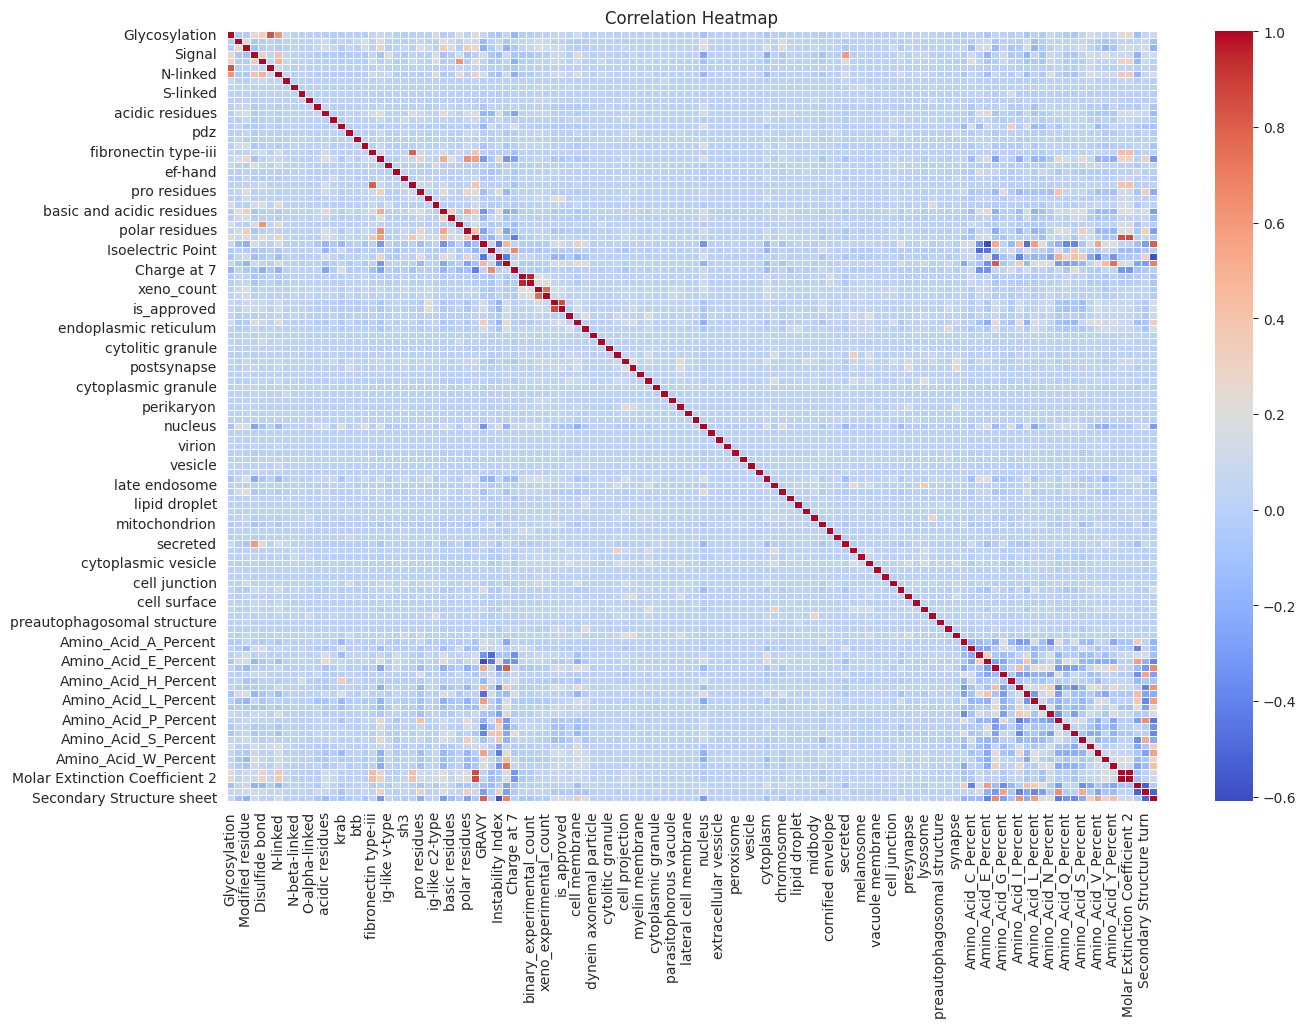

In [36]:
okk_1 = data.copy()
plt.figure(figsize=(15, 10))
sns.heatmap(okk_1.corr(), cmap='coolwarm', annot=False, fmt=".2f",linewidth= 0.5)
plt.title('Correlation Heatmap')
plt.show()

In [37]:
location_data = okk_1.iloc[:,23:73]

n_components = 50
pca_list = []
feature_weight_list = []
for i in range(1,n_components):
  PCAmod = PCA(n_components = i)
  PCAmod.fit(location_data)
  pca_list.append(pd.Series({
      "n" : i,
      "model" : PCAmod,
      "var" : PCAmod.explained_variance_ratio_.sum(),
  }))
  weights = PCAmod.explained_variance_ratio_.reshape(-1, 1) / PCAmod.explained_variance_ratio_.sum()
  overall_contributions = np.abs(PCAmod.components_) * weights
  abs_feature_values = overall_contributions.sum(axis=0)
  feature_weight_list.append(pd.DataFrame({
      'n': i,
      'features': location_data.columns,
      'values': abs_feature_values / abs_feature_values.sum(),
  }))
pca_report = pd.DataFrame(pca_list)
feature_importance_report = pd.concat(feature_weight_list).pivot(index='n', columns='features', values='values')

In [38]:
pca_report

,n,model,var
0,1,PCA(n_components=1),0.155587
1,2,PCA(n_components=2),0.275962
2,3,PCA(n_components=3),0.376054
3,4,PCA(n_components=4),0.452757
4,5,PCA(n_components=5),0.521605
5,6,PCA(n_components=6),0.577488
6,7,PCA(n_components=7),0.630747
7,8,PCA(n_components=8),0.683107
8,9,PCA(n_components=9),0.734326
9,10,PCA(n_components=10),0.782998


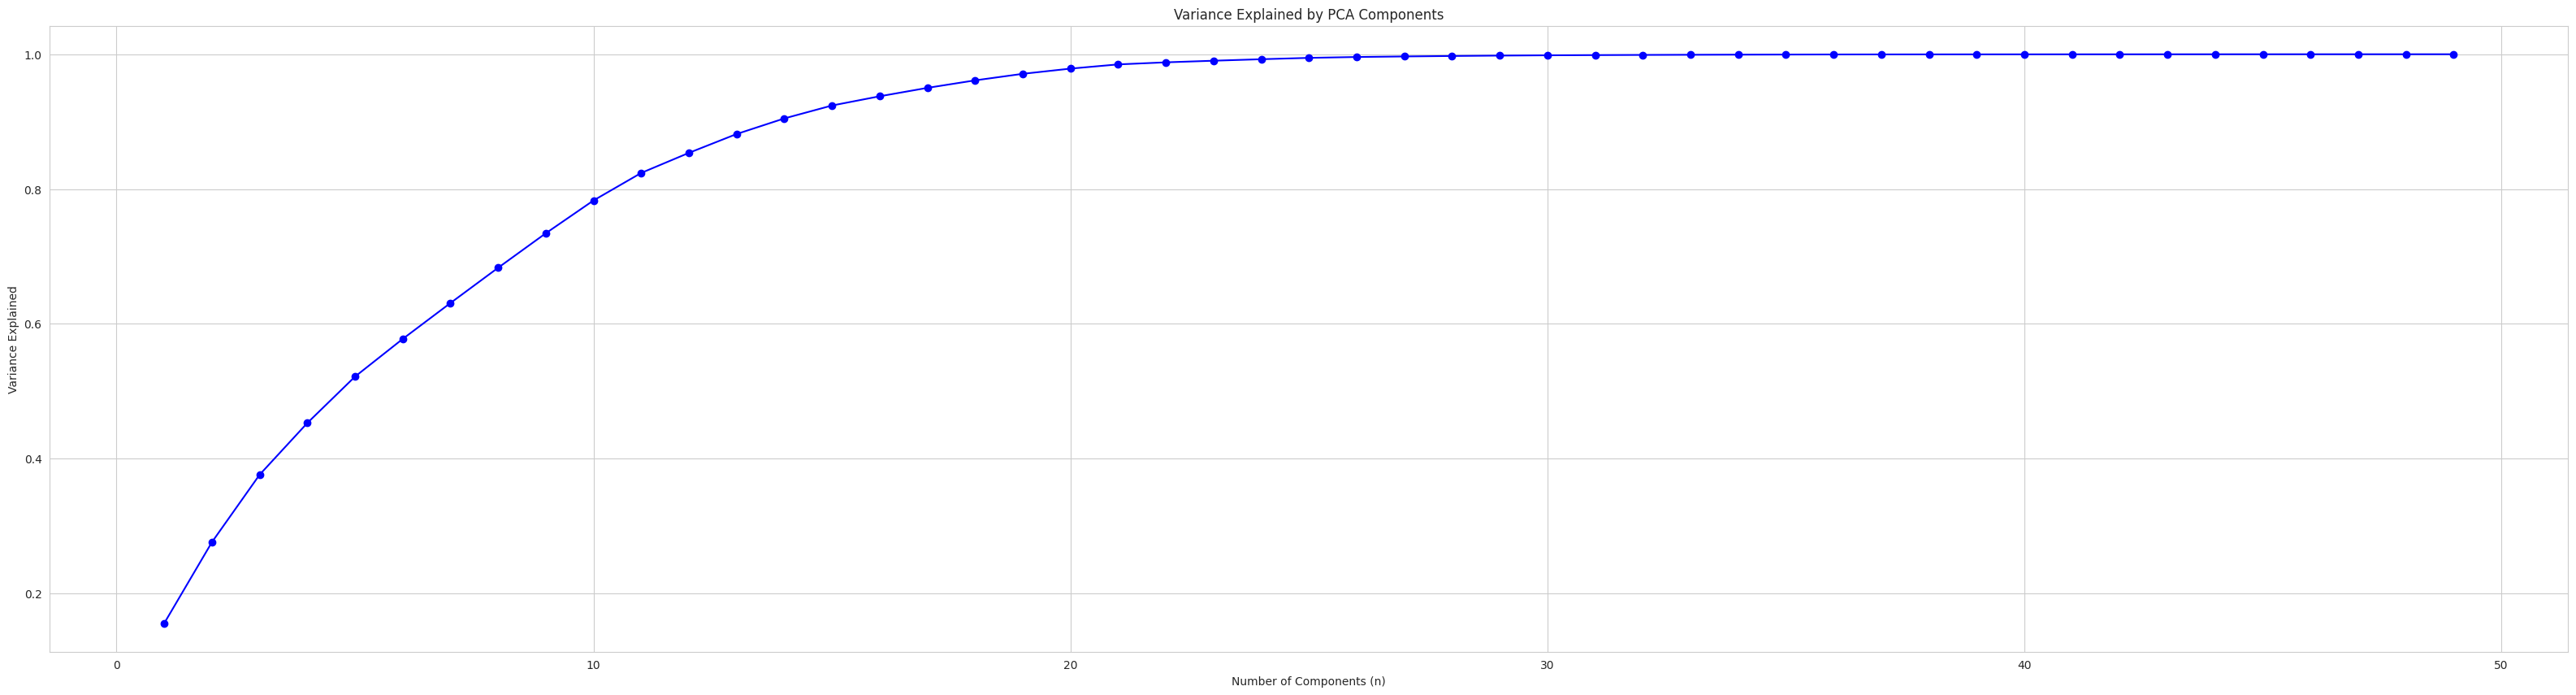

In [39]:
fig,ax = plt.subplots(figsize = (40,10))
plt.plot(pca_report['n'], pca_report['var'], marker = 'o', linestyle = "-", color = 'b')
plt.title('Variance Explained by PCA Components')
# plt.axvline(x=150, color='r', linestyle='--', linewidth=2, label='Threshold at x=50')
plt.xlabel('Number of Components (n)')
plt.ylabel('Variance Explained')
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[Text(0.5, 24.0, 'Number of components'),
 Text(23.999999999999993, 0.5, 'Relative Importance'),
 Text(0.5, 1.0, 'Feature Importance Vs Dimensions')]

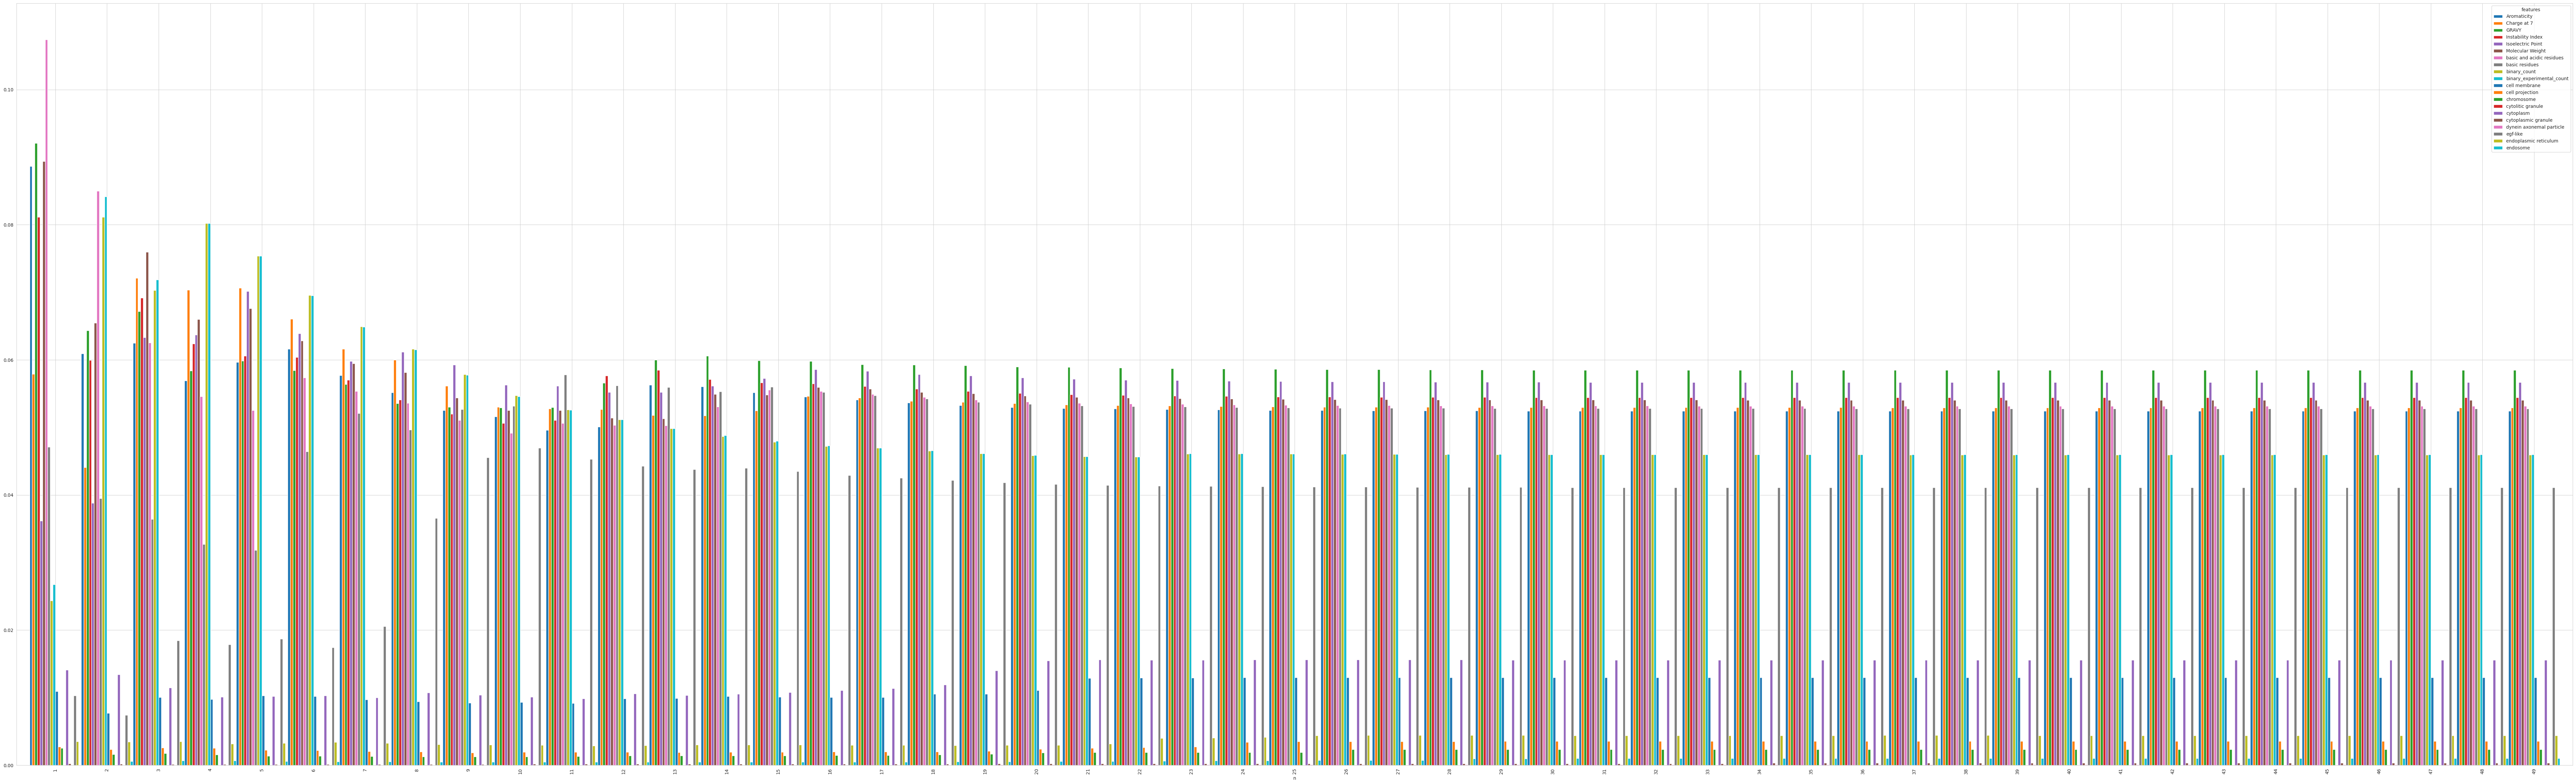

In [40]:
x = feature_importance_report.iloc[:,:20].plot(kind = 'bar' , figsize = (100,30), width=1)
ax.legend(loc = 'upper right')
ax.set(xlabel = 'Number of components' ,  ylabel = 'Relative Importance' , title = 'Feature Importance Vs Dimensions')

<Figure size 2000x1200 with 0 Axes>

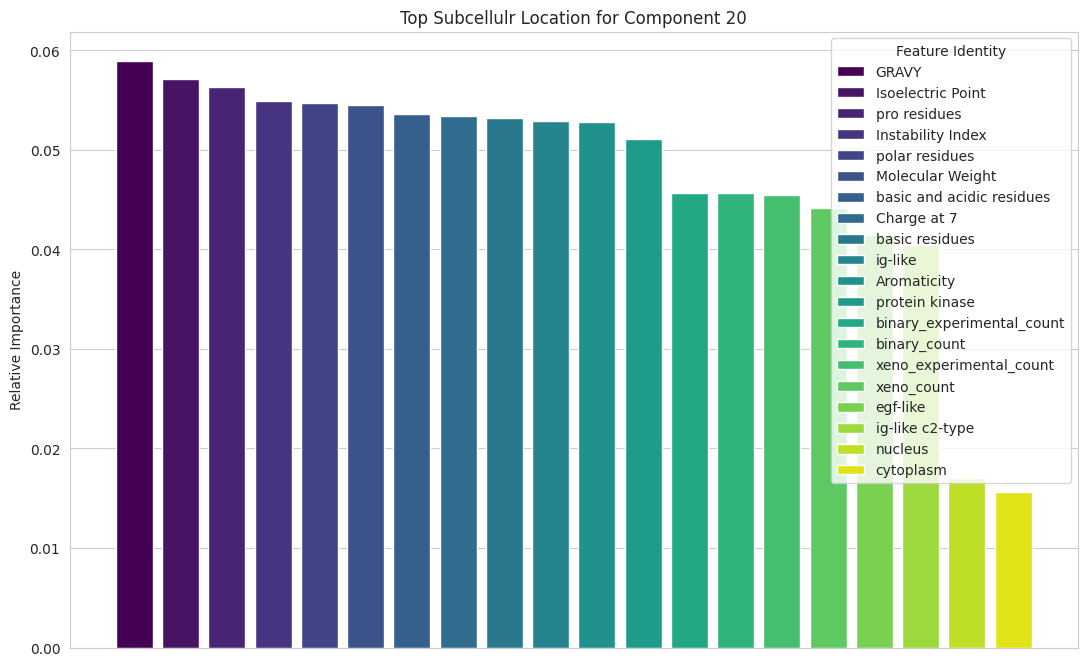

In [41]:
plt.figure(figsize= (20,12))
n_top_features = 20
top_features = feature_importance_report.iloc[20].nlargest(n_top_features)
fig, ax = plt.subplots(figsize=(13, 8))

for idx, (feature, importance) in enumerate(top_features.items()):
    ax.bar(idx, importance, label=feature, color=plt.cm.viridis(idx / len(top_features)))

ax.set_xticks([])

ax.legend(loc='upper right', title='Feature Identity')

ax.set(ylabel='Relative Importance', title='Top Subcellulr Location for Component 20')
plt.show()

In [42]:
#PCA Analysis for reduction and selection of relevant ones

n_components = 50
pca_list = []
feature_weight_list = []
for i in range(1,n_components):
  PCAmod = PCA(n_components = i)
  PCAmod.fit(okk_1)
  pca_list.append(pd.Series({
      "n" : i,
      "model" : PCAmod,
      "var" : PCAmod.explained_variance_ratio_.sum(),
  }))
  weights = PCAmod.explained_variance_ratio_.reshape(-1, 1) / PCAmod.explained_variance_ratio_.sum()
  overall_contributions = np.abs(PCAmod.components_) * weights
  abs_feature_values = overall_contributions.sum(axis=0)
  feature_weight_list.append(pd.DataFrame({
      'n': i,
      'features': okk_1.columns,
      'values': abs_feature_values / abs_feature_values.sum(),
  }))
pca_report = pd.DataFrame(pca_list)
feature_importance_report = pd.concat(feature_weight_list).pivot(index='n', columns='features', values='values')

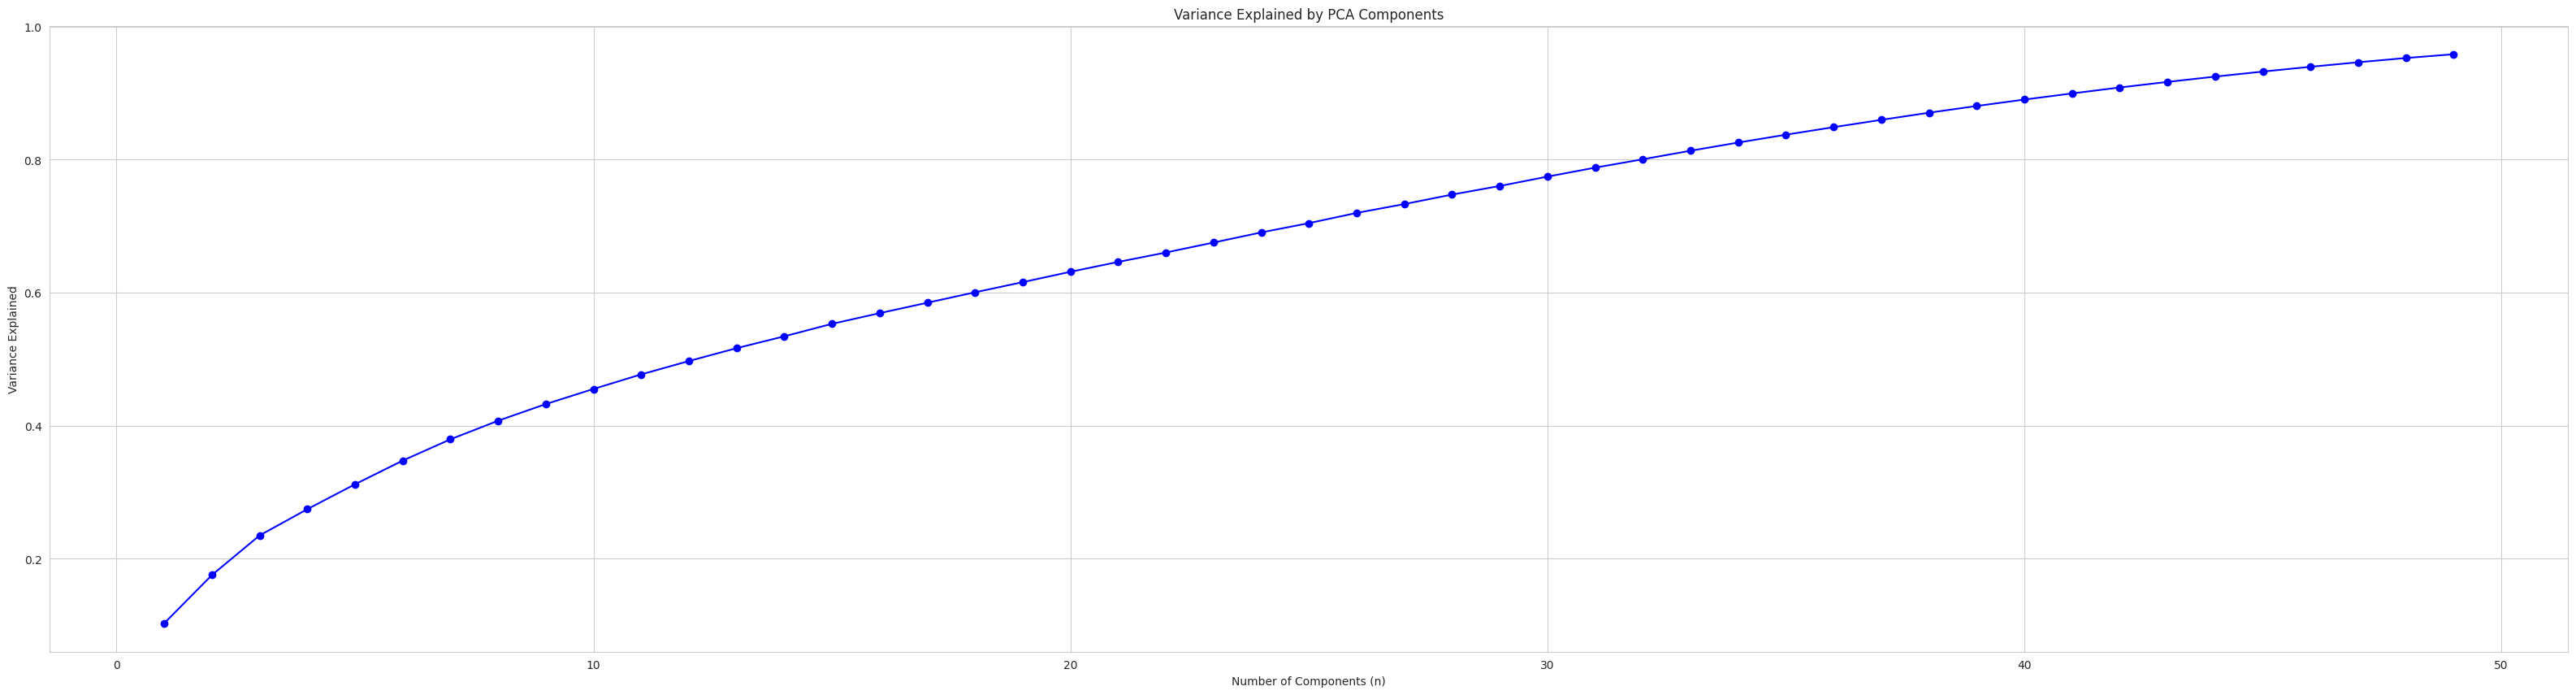

In [43]:
fig,ax = plt.subplots(figsize = (40,10))
plt.plot(pca_report['n'], pca_report['var'], marker = 'o', linestyle = "-", color = 'b')
plt.title('Variance Explained by PCA Components')
# plt.axvline(x=150, color='r', linestyle='--', linewidth=2, label='Threshold at x=50')
plt.xlabel('Number of Components (n)')
plt.ylabel('Variance Explained')
plt.grid(True)
plt.show()

[Text(0.5, 0, 'Number of components'),
 Text(0, 0.5, 'Relative Importance'),
 Text(0.5, 1.0, 'Feature Importance Vs Dimensions')]

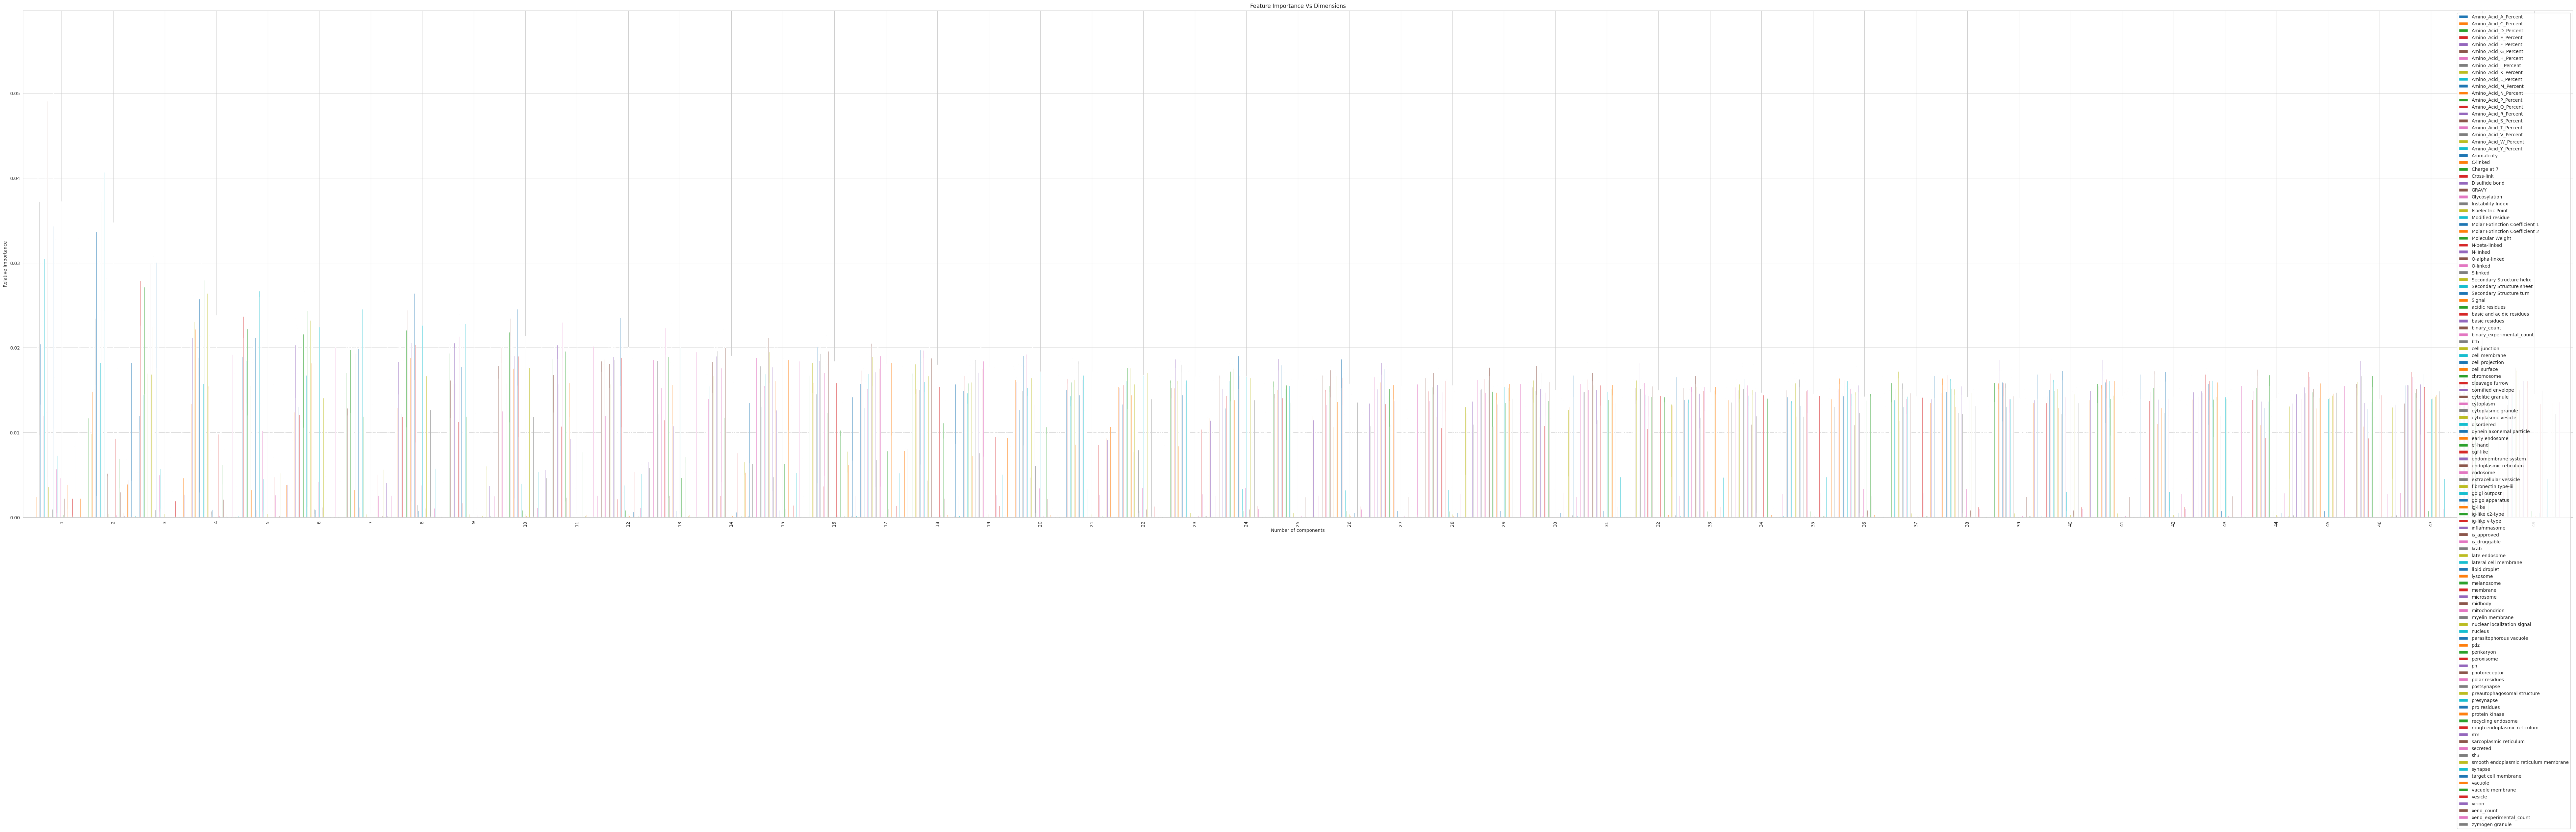

In [44]:
ax = feature_importance_report.plot(kind = 'bar' , figsize = (100,20), width=1)
ax.legend(loc = 'upper right')
ax.set(xlabel = 'Number of components' ,  ylabel = 'Relative Importance' , title = 'Feature Importance Vs Dimensions')

<Figure size 2000x1200 with 0 Axes>

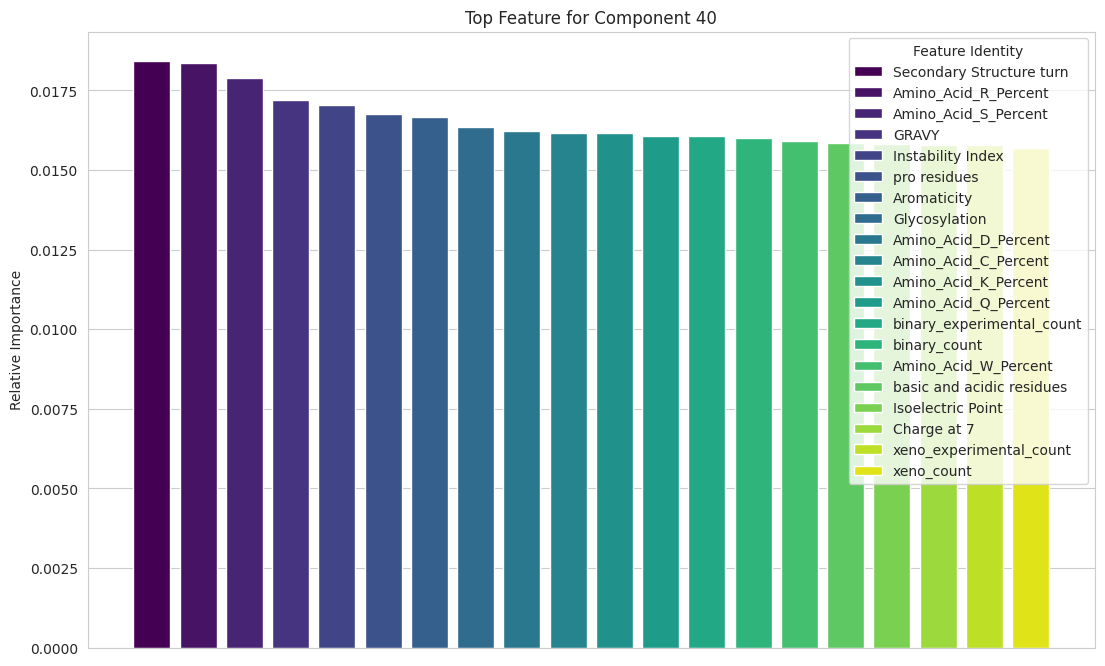

In [45]:
plt.figure(figsize= (20,12))
n_top_features = 20
top_features = feature_importance_report.iloc[29].nlargest(n_top_features)
fig, ax = plt.subplots(figsize=(13, 8))

for idx, (feature, importance) in enumerate(top_features.items()):
    ax.bar(idx, importance, label=feature, color=plt.cm.viridis(idx / len(top_features)))

ax.set_xticks([])

ax.legend(loc='upper right', title='Feature Identity')

ax.set(ylabel='Relative Importance', title='Top Feature for Component 40')
plt.show()

<Figure size 2000x1200 with 0 Axes>

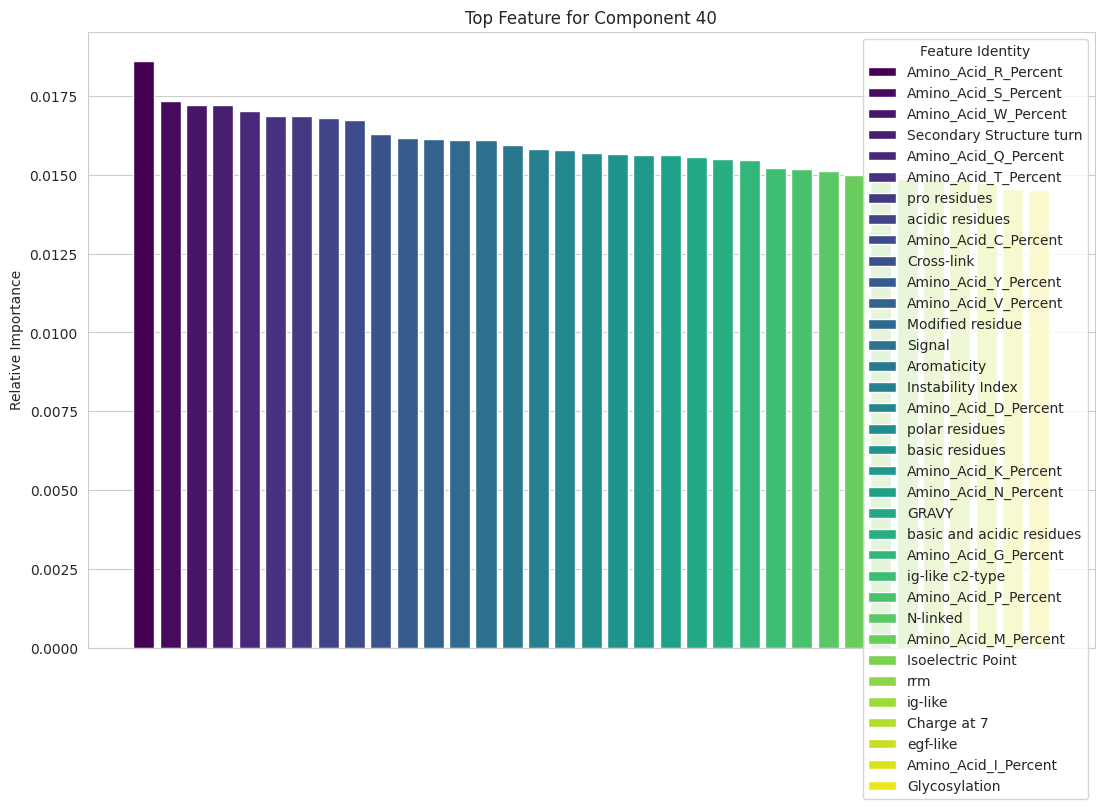

In [46]:
plt.figure(figsize= (20,12))
n_top_features = 35
top_features = feature_importance_report.iloc[40].nlargest(n_top_features)
fig, ax = plt.subplots(figsize=(13, 8))

for idx, (feature, importance) in enumerate(top_features.items()):
    ax.bar(idx, importance, label=feature, color=plt.cm.viridis(idx / len(top_features)))

ax.set_xticks([])

ax.legend(loc='upper right', title='Feature Identity')

ax.set(ylabel='Relative Importance', title='Top Feature for Component 40')
plt.show()

midbody                    0.000000
cytolitic granule          0.000000
myelin membrane            0.000000
target cell membrane       0.000000
parasitophorous vacuole    0.000000
                             ...   
microsome                  0.026677
Disulfide bond             0.026814
Modified residue           0.036410
Glycosylation              0.039691
protein kinase             0.088683
Length: 116, dtype: float32


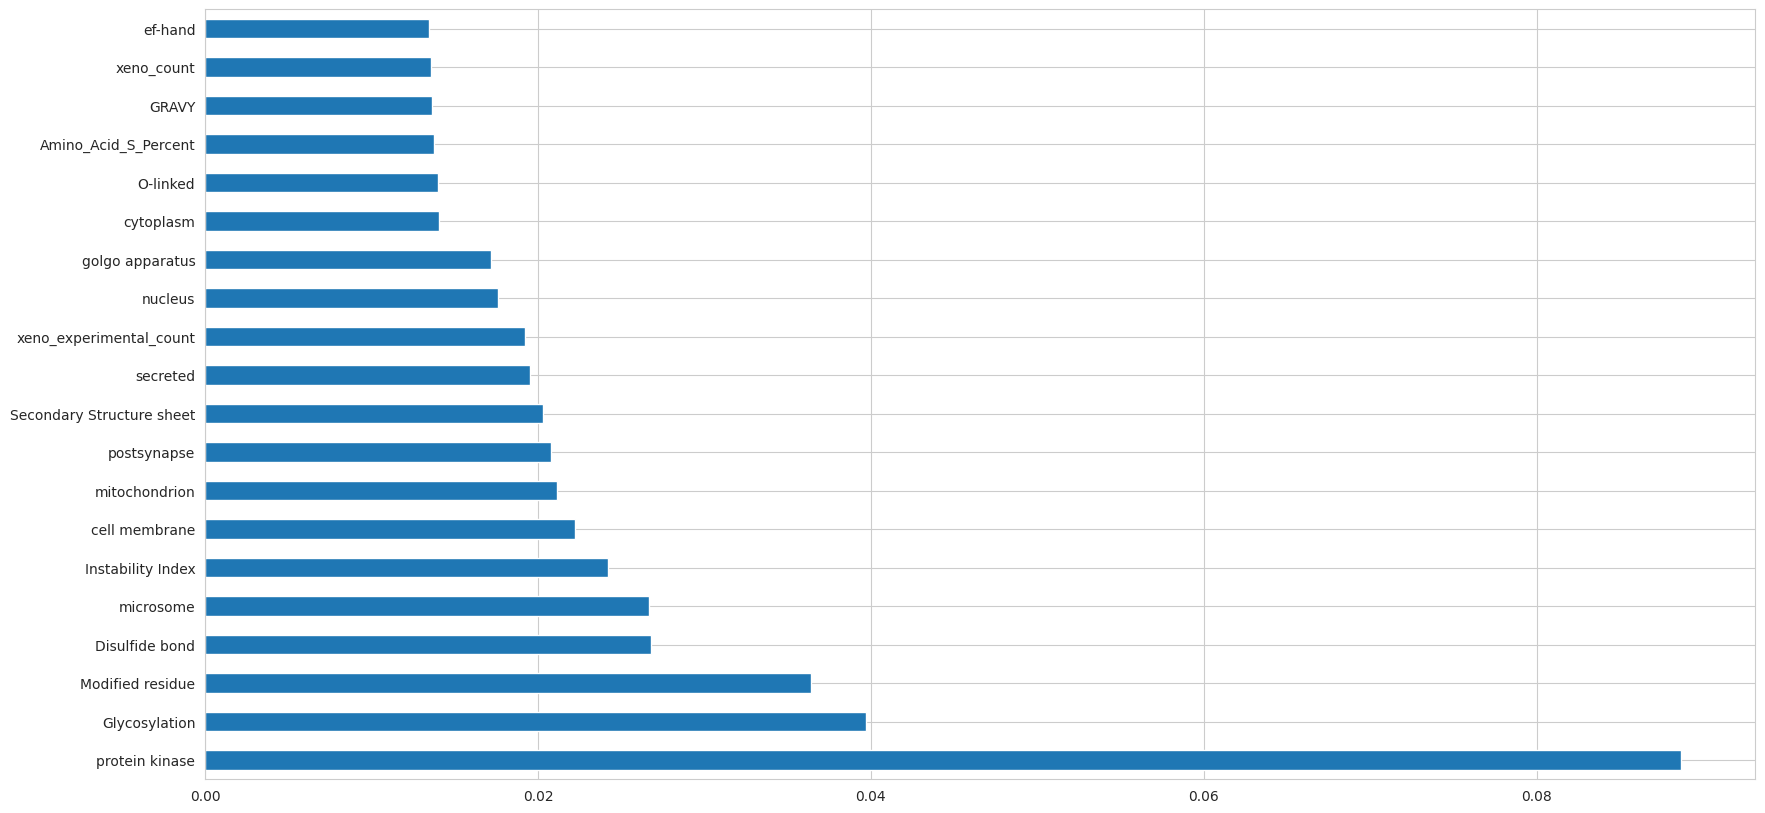

In [47]:
#lets see each feature importance using XGB Classifier
okk_1 = okk_1.drop(columns = ['is_approved'])
import xgboost

x_sample = okk_1.drop(columns = ['is_druggable'])
y_sample = okk_1['is_druggable']

model = xgboost.XGBClassifier()
model.fit(x_sample,y_sample)

feat_imp = pd.Series(model.feature_importances_, index=x_sample.columns)
print(feat_imp.sort_values())
feat_imp.nlargest(20).plot(kind='barh',figsize=(20,10))

plt.show()

In [48]:
druggable_indices = (y_sample == 1)  # Assuming 1 represents druggable
non_druggable_indices = (y_sample == 0)  # Assuming 0 represents non-druggable

druggable_X = x_sample[druggable_indices]
druggable_y = y_sample[druggable_indices]

non_druggable_X = x_sample[non_druggable_indices]
non_druggable_y = y_sample[non_druggable_indices]

In [49]:
class_size = 1000
druggable_X_remaining, druggable_X_test, druggable_y_remaining, druggable_y_test = train_test_split(druggable_X, druggable_y, test_size=class_size, random_state=123)
non_druggable_X_remaining, non_druggable_X_test, non_druggable_y_remaining, non_druggable_y_test = train_test_split(non_druggable_X, non_druggable_y, test_size=class_size, random_state=123)

In [ ]:
X_test = pd.concat((druggable_X_test, non_druggable_X_test))
y_test = pd.concat((druggable_y_test, non_druggable_y_test))

X_train = pd.concat((druggable_X_remaining, non_druggable_X_remaining))
y_train = pd.concat((druggable_y_remaining, non_druggable_y_remaining))

len(y_train), sum(y_train), len(y_test), sum(y_test)

In [51]:
#model building
sc = StandardScaler()
oversample = SMOTE()
X_train,y_train = oversample.fit_resample(X_train,y_train)

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#using xgboost boosting algorithms
model_1 = xgboost.XGBClassifier()
model_1.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [52]:
from sklearn.model_selection import cross_validate

def test_results(model, k):
  results = {}
  scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
  okk = cross_validate(model, X_test, y_test, cv=k, scoring=scoring)

  for metric in scoring:
    mean_score = np.mean(okk['test_' + metric])
    results[metric] = mean_score


  return results

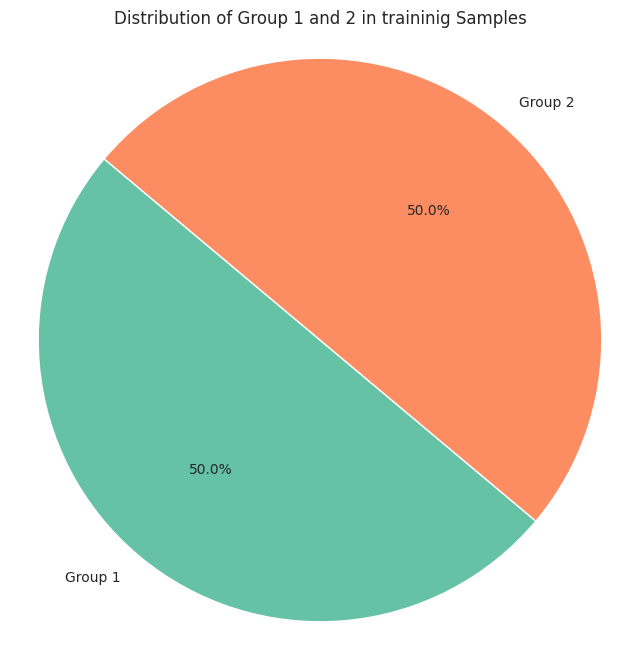

In [53]:
group_counts = pd.Series(y_train).value_counts()
group1_count = group_counts[1]
group2_count = group_counts[0]

# Plotting
plt.figure(figsize=(8, 8))
plt.pie([group1_count, group2_count], labels=['Group 1', 'Group 2'], autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62'])
plt.title('Distribution of Group 1 and 2 in traininig Samples')
plt.axis('equal')
plt.show()

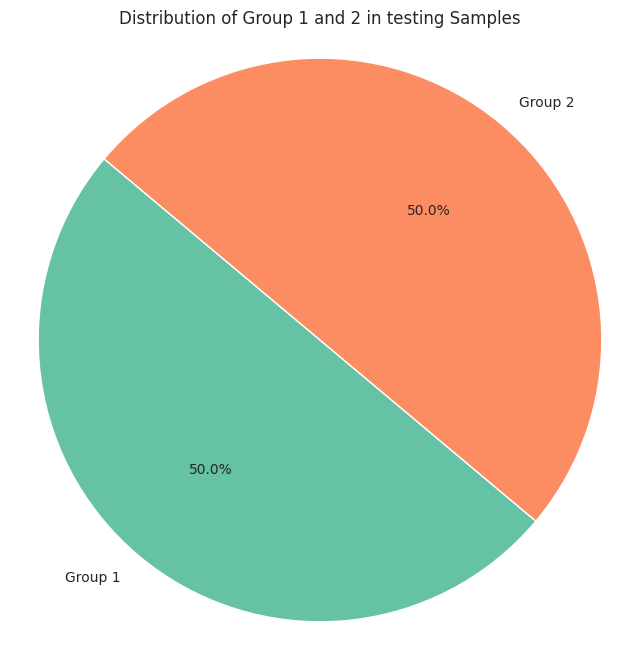

In [54]:
group_counts = pd.Series(y_test).value_counts()
group1_count = group_counts[1]
group2_count = group_counts[0]

# Plotting
plt.figure(figsize=(8, 8))
plt.pie([group1_count, group2_count], labels=['Group 1', 'Group 2'], autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62'])
plt.title('Distribution of Group 1 and 2 in testing Samples')
plt.axis('equal')
plt.show()

In [55]:
y_pred = model_1.predict(X_test)
metrics_1 = test_results(model_1, 5)

In [56]:
metrics_1

{'accuracy': 0.7374999999999999,
 'precision_weighted': 0.7381448428977118,
 'recall_weighted': 0.7374999999999999,
 'f1_weighted': 0.7372970497197695}

In [57]:
#using logistic regression algorithm
model_2 = LogisticRegression(max_iter = 1000)
model_2.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [58]:
y_pred_2 = model_2.predict(X_test)
metrics_2= test_results(model_2, 5)
metrics_2

{'accuracy': 0.712,
 'precision_weighted': 0.7123889076156351,
 'recall_weighted': 0.712,
 'f1_weighted': 0.7118778249738501}

In [59]:
#using SVM algorithm using various kernels
model_3 = svm.SVC(kernel = 'linear',probability = True)
model_4 = svm.SVC(kernel = 'poly',probability = True)
model_5 = svm.SVC(kernel = 'rbf',probability = True)

model_3.fit(X_train,y_train)
model_4.fit(X_train,y_train)
model_5.fit(X_train,y_train)

SVC(probability=True)

In [60]:
y_pred_3 = model_3.predict(X_test)
metrics_3= test_results(model_3, 5)

y_pred_4 = model_4.predict(X_test)
metrics_4= test_results(model_4, 5)

y_pred_5 = model_3.predict(X_test)
metrics_5 = test_results(model_5, 5)

In [61]:
#using RandomForest with estimator = 1500 which is no of trees employed
model_6 = RandomForestClassifier(n_estimators = 1500, criterion = 'entropy', random_state = 42)
model_6.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=1500, random_state=42)

In [62]:
y_pred_6 = model_6.predict(X_test)
metrics_6= test_results(model_6, 5)

In [63]:
#using ANN for classification

import tensorflow as tf
from tensorflow.keras import layers

model_7 = tf.keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])

# Compile model
model_7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [64]:
history = model_7.fit(X_train, y_train, validation_data = (X_test,y_test), epochs = 50)

Epoch 1/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7573 - loss: 0.5246 - val_accuracy: 0.7010 - val_loss: 0.7307
Epoch 2/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8341 - loss: 0.3839 - val_accuracy: 0.6995 - val_loss: 0.7227
Epoch 3/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 1s 976us/step - accuracy: 0.8589 - loss: 0.3343 - val_accuracy: 0.7030 - val_loss: 0.7956
Epoch 4/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 1s 962us/step - accuracy: 0.8809 - loss: 0.2901 - val_accuracy: 0.7095 - val_loss: 0.8277
Epoch 5/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step - accuracy: 0.8943 - loss: 0.2617 - val_accuracy: 0.7110 - val_loss: 0.8177
Epoch 6/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 1s 986us/step - accuracy: 0.9070 - loss: 0.2426 - val_accuracy: 0.7035 - val_loss: 0.9530
Epoch 7/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step - accuracy: 0.9187 - loss: 0.2149 - val_accuracy: 0.6835 - val_loss: 1.1537
Epoch 8/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9227 - loss:

In [65]:
print(len(X_test))
y_pred_7 = model_7.predict(X_test)
print(len(y_pred_7))
y_pred_7 = (y_pred_7 >= 0.5).astype(int)
metrics_7 = {
  'accuracy' : accuracy_score(y_test,y_pred),
  'precision_weighted' : precision_score(y_test,y_pred,average = 'weighted'),
  'recall_weighted' : recall_score(y_test,y_pred,average = 'weighted'),
  'f1_weighted' : f1_score(y_test,y_pred,average = 'weighted'),
}

2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
2000


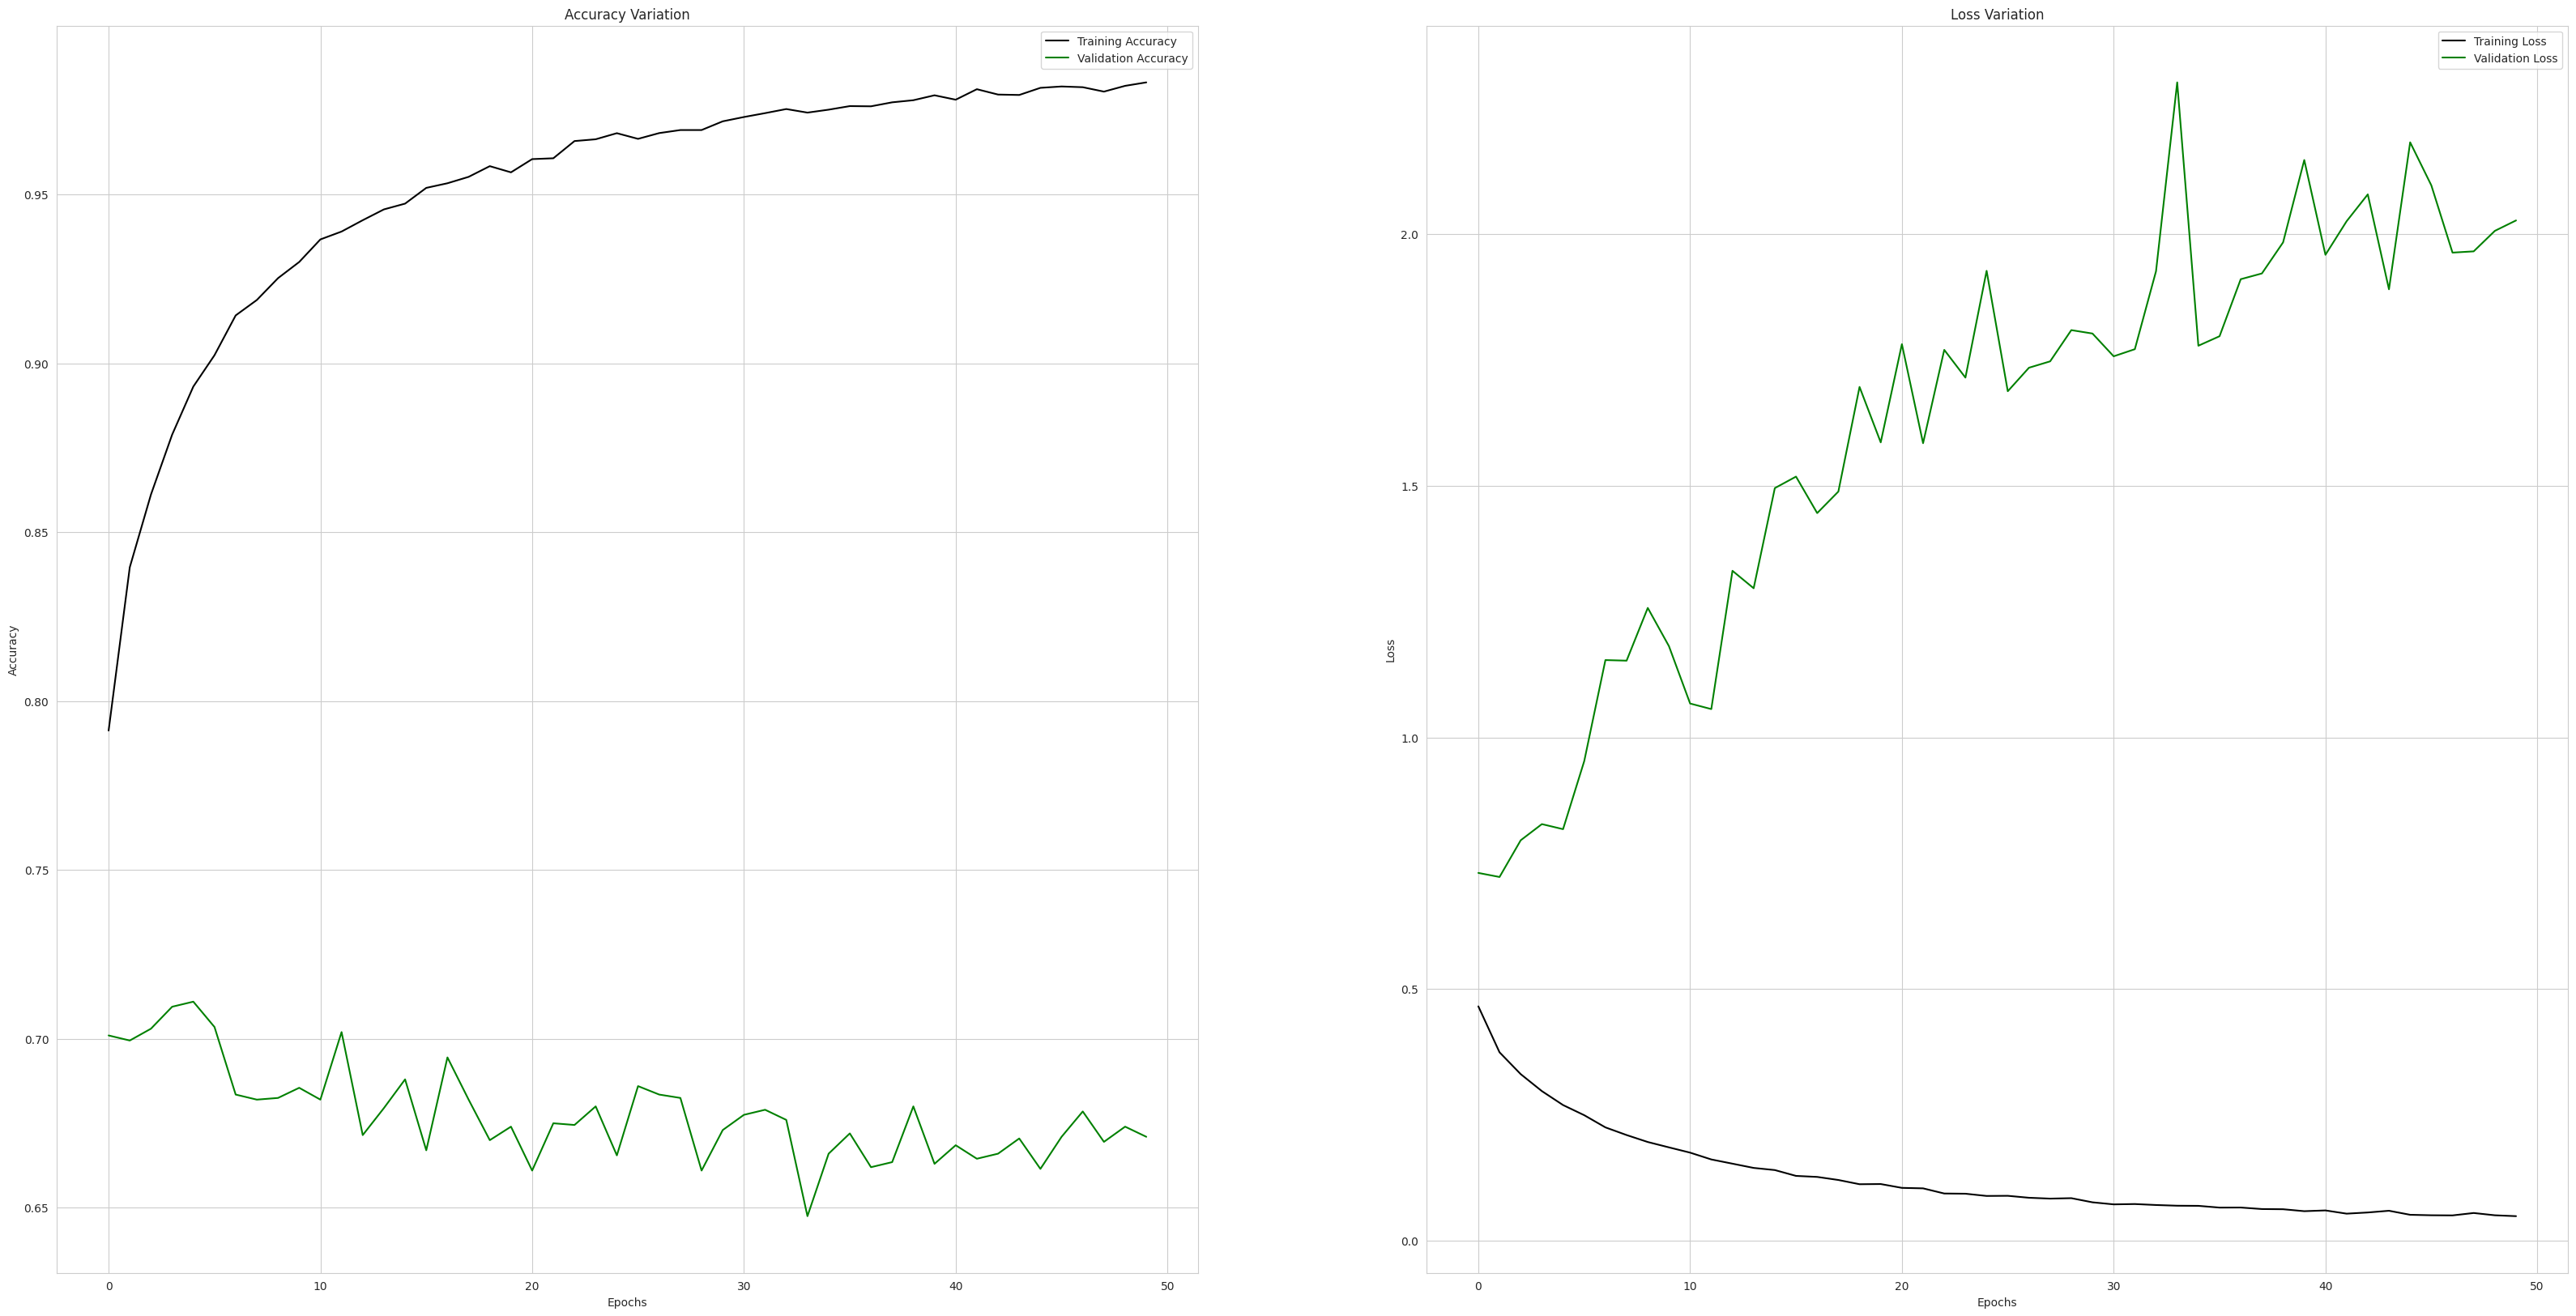

In [66]:
fig,ax = plt.subplots(figsize = (40,20), ncols = 2)
ax[0].plot(history.history['accuracy'],color = 'black', label = 'Training Accuracy')
ax[0].plot(history.history['val_accuracy'],color = 'green', label = 'Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Accuracy Variation')
ax[0].legend()

ax[1].plot(history.history['loss'],color = 'black', label = 'Training Loss')
ax[1].plot(history.history['val_loss'],color = 'green', label = 'Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_title('Loss Variation')
ax[1].legend()
plt.show()

In [67]:
from sklearn.linear_model import SGDClassifier
model_8 = SGDClassifier(loss='log_loss', penalty='elasticnet', alpha=0.5, l1_ratio=0.5)
model_8.fit(X_train, y_train)

SGDClassifier(alpha=0.5, l1_ratio=0.5, loss='log_loss', penalty='elasticnet')

In [68]:
y_pred_8 = model_8.predict(X_test)
metrics_8 = test_results(model_8, 5)

/home/aria/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aria/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aria/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aria/anaconda

In [69]:
model_list = {
    "XGBoost" : pd.Series(metrics_1),
    "Logistic_Regression" : pd.Series(metrics_2),
    "SVM_Linear" : pd.Series(metrics_3),
    "SVM_Polynomial" : pd.Series(metrics_4),
    "SVM_RBF" : pd.Series(metrics_5),
    "Random_Forest" : pd.Series(metrics_6),
    "ANN" : pd.Series(metrics_7),
    "SGD_Elastic_Net" : pd.Series(metrics_8),
}

pd.DataFrame(model_list).T


,accuracy,precision_weighted,recall_weighted,f1_weighted
XGBoost,0.7375,0.738145,0.7375,0.737297
Logistic_Regression,0.7120,0.712389,0.7120,0.711878
SVM_Linear,0.7165,0.717227,0.7165,0.716299
SVM_Polynomial,0.5630,0.638181,0.5630,0.494580
SVM_RBF,0.7290,0.732713,0.7290,0.728003
Random_Forest,0.7480,0.748763,0.7480,0.747818
ANN,0.6560,0.736742,0.6560,0.623935
SGD_Elastic_Net,0.5000,0.250000,0.5000,0.333333


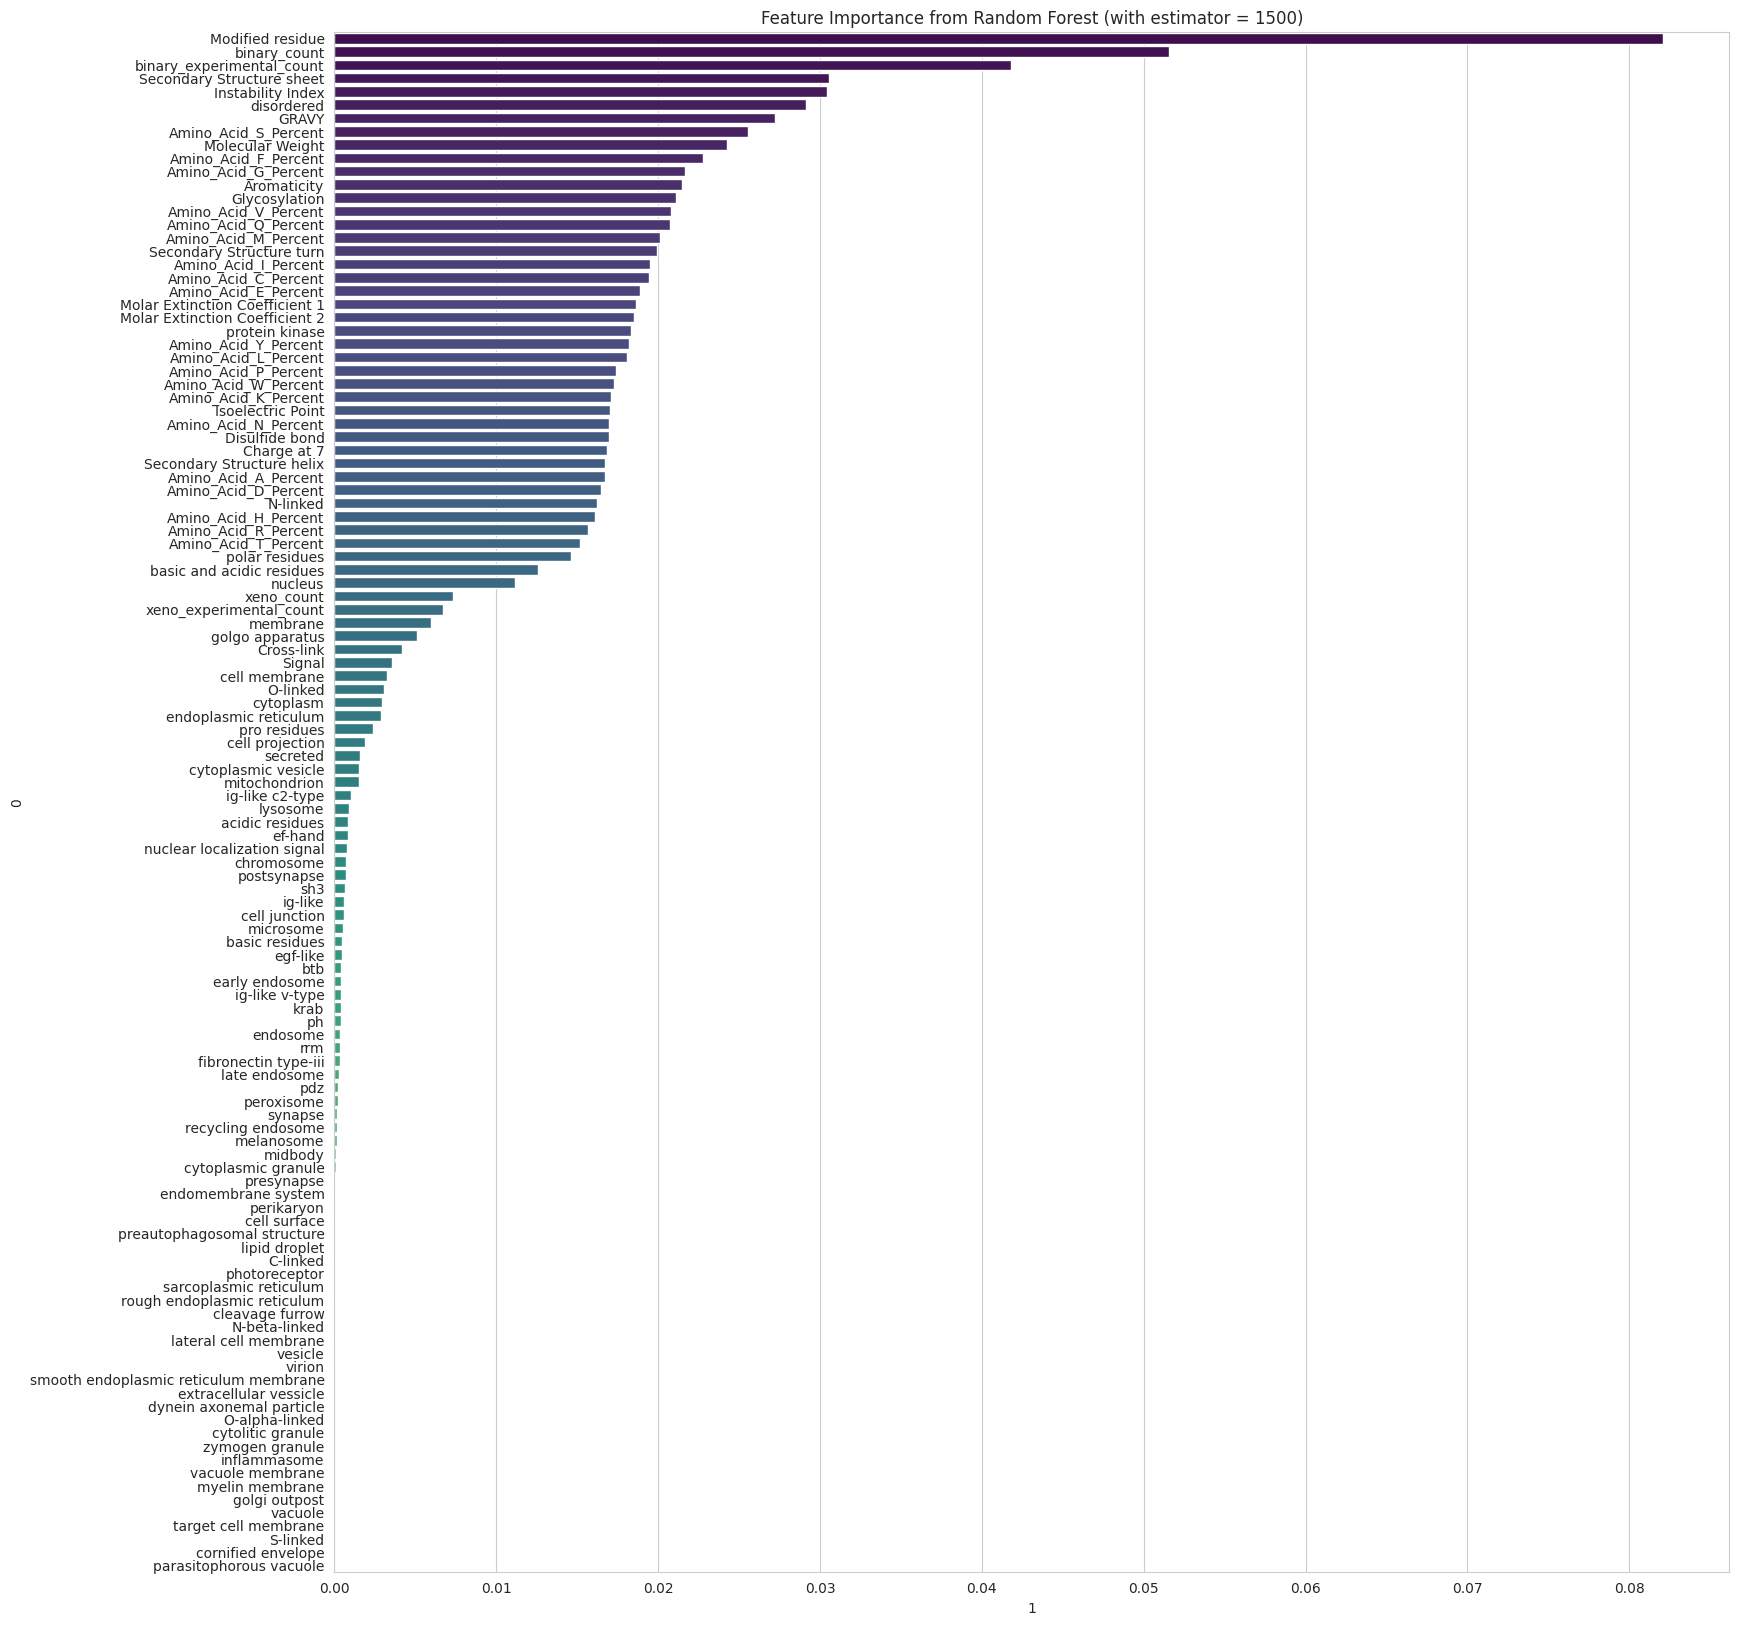

In [70]:
feature_importance = model_6.feature_importances_
okk = pd.DataFrame([x_sample.columns, feature_importance]).T
okk = okk.sort_values(by = 1,ascending = False)
plt.figure(figsize=(18, 20))
sns.barplot(x = okk[1], y = okk[0], data = okk, palette='viridis')
plt.title("Feature Importance from Random Forest (with estimator = 1500)")
plt.show()

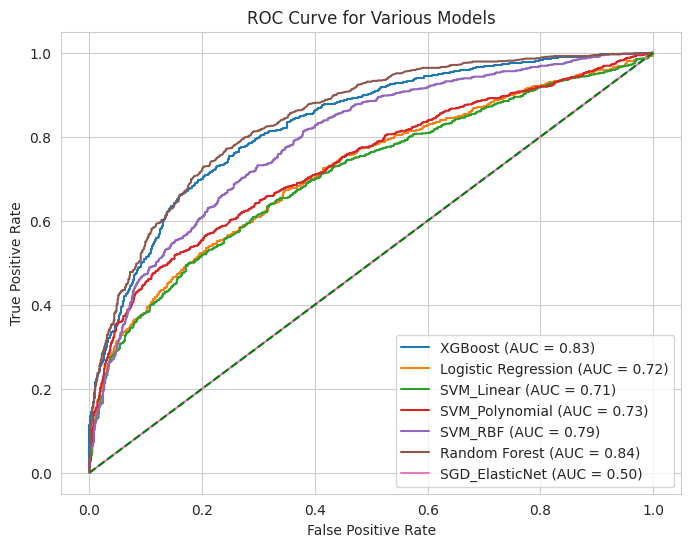

In [71]:
#roc-auc curve for various algorithm
fpr_1, tpr_1, _ = roc_curve(y_test, model_1.predict_proba(X_test)[:, 1])
fpr_2, tpr_2, _ = roc_curve(y_test, model_2.predict_proba(X_test)[:, 1])
fpr_3, tpr_3, _ = roc_curve(y_test, model_3.predict_proba(X_test)[:, 1])
fpr_4, tpr_4, _ = roc_curve(y_test, model_4.predict_proba(X_test)[:, 1])
fpr_5, tpr_5, _ = roc_curve(y_test, model_5.predict_proba(X_test)[:, 1])
fpr_6, tpr_6, _ = roc_curve(y_test, model_6.predict_proba(X_test)[:, 1])
fpr_8, tpr_8, _ = roc_curve(y_test, model_8.predict_proba(X_test)[:, 1])

from sklearn.metrics import roc_auc_score

auc_1 = roc_auc_score(y_test, model_1.predict_proba(X_test)[:, 1])
auc_2 = roc_auc_score(y_test, model_2.predict_proba(X_test)[:, 1])
auc_3 = roc_auc_score(y_test, model_3.predict_proba(X_test)[:, 1])
auc_4 = roc_auc_score(y_test, model_4.predict_proba(X_test)[:, 1])
auc_5 = roc_auc_score(y_test, model_5.predict_proba(X_test)[:, 1])
auc_6 = roc_auc_score(y_test, model_6.predict_proba(X_test)[:, 1])
auc_8 = roc_auc_score(y_test, model_8.predict_proba(X_test)[:, 1])

# Plot ROC curves for each model with AUC values in the legend
plt.figure(figsize=(8, 6))
plt.plot(fpr_1, tpr_1, label=f'XGBoost (AUC = {auc_1:.2f})')
plt.plot(fpr_2, tpr_2, label=f'Logistic Regression (AUC = {auc_2:.2f})')
plt.plot(fpr_3, tpr_3, label=f'SVM_Linear (AUC = {auc_3:.2f})')
plt.plot(fpr_4, tpr_4, label=f'SVM_Polynomial (AUC = {auc_4:.2f})')
plt.plot(fpr_5, tpr_5, label=f'SVM_RBF (AUC = {auc_5:.2f})')
plt.plot(fpr_6, tpr_6, label=f'Random Forest (AUC = {auc_6:.2f})')
plt.plot(fpr_8, tpr_8, label=f'SGD_ElasticNet (AUC = {auc_8:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='green', linestyle='--')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Various Models')
plt.legend()
plt.show()

In [72]:
import pycaret
pycaret.__version__

'3.3.2'

In [73]:
from pycaret.classification import *
setup(data = x_sample, target = y_sample, session_id = 123)
best_models = compare_models()

,Description,Value
0,Session id,123
1,Target,is_druggable
2,Target type,Binary
3,Original data shape,"(20434, 117)"
4,Transformed data shape,"(20434, 117)"
5,Transformed train set shape,"(14303, 117)"
6,Transformed test set shape,"(6131, 117)"
7,Numeric features,116
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8640,0.8509,0.3268,0.6740,0.4398,0.3730,0.4049,0.3590
gbc,Gradient Boosting Classifier,0.8613,0.8369,0.2785,0.6888,0.3961,0.3335,0.3776,2.1950
xgboost,Extreme Gradient Boosting,0.8604,0.8390,0.3567,0.6305,0.4552,0.3822,0.4029,0.1860
et,Extra Trees Classifier,0.8600,0.8504,0.2136,0.7570,0.3326,0.2809,0.3524,0.3630
rf,Random Forest Classifier,0.8598,0.8416,0.1841,0.8180,0.2997,0.2554,0.3452,0.6730
ada,Ada Boost Classifier,0.8516,0.8170,0.2875,0.5963,0.3871,0.3145,0.3420,0.4380
lr,Logistic Regression,0.8495,0.7939,0.1867,0.6351,0.2870,0.2306,0.2856,0.4070
lda,Linear Discriminant Analysis,0.8472,0.7907,0.2196,0.5926,0.3163,0.2513,0.2924,0.0410
ridge,Ridge Classifier,0.8462,0.7902,0.1354,0.6415,0.2222,0.1759,0.2431,0.0330
knn,K Neighbors Classifier,0.8461,0.7700,0.3495,0.5464,0.4257,0.3419,0.3536,0.2120


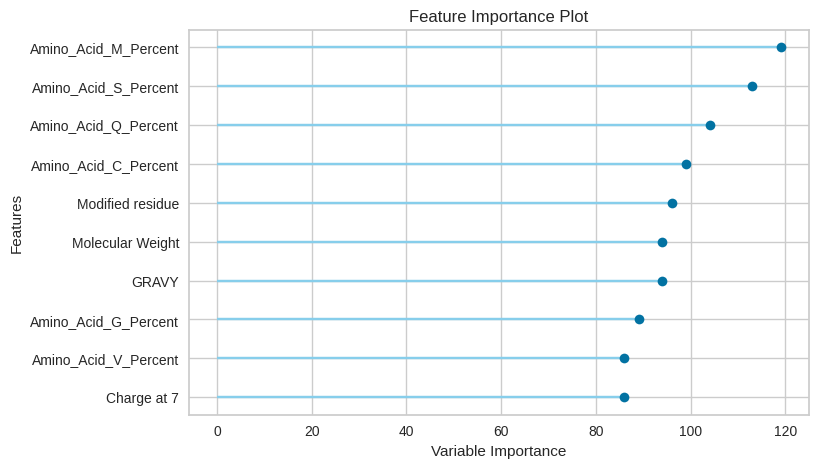

In [74]:
plot_model(best_models, plot = 'feature')

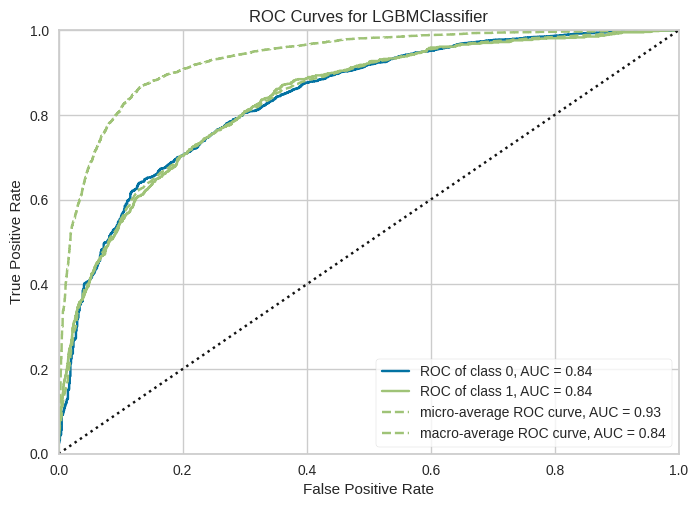

In [75]:
plot_model(best_models, plot = 'auc')

K-old Cross Validation (5 folds)

In [76]:
#using model_1 - XGBoost Classifier
from sklearn.model_selection import KFold

x_sample.reset_index(drop=True, inplace=True)

kf = KFold(n_splits=5)

precision = {
    "XGBoost" : [],
    "Logistic_Regression" : [],
    'SVM_Linear' : [],
    'SVM_Poly' : [],
    'SVM_RBF' : [],
    'Random_Forest' : [],
    'ANN' : [],

}
recall = {
    "XGBoost" : [],
    "Logistic_Regression" : [],
    'SVM_Linear' : [],
    'SVM_Poly' : [],
    'SVM_RBF' : [],
    'Random_Forest' : [],
    'ANN' : [],

}
f1 = {
    "XGBoost" : [],
    "Logistic_Regression" : [],
    'SVM_Linear' : [],
    'SVM_Poly' : [],
    'SVM_RBF' : [],
    'Random_Forest' : [],
    'ANN' : [],

}
accuracy = {
    "XGBoost" : [],
    "Logistic_Regression" : [],
    'SVM_Linear' : [],
    'SVM_Poly' : [],
    'SVM_RBF' : [],
    'Random_Forest' : [],
    'ANN' : [],
}

for fold, (train_index, test_index) in enumerate(kf.split(x_sample)):
    X_train = x_sample.loc[train_index]
    y_train = y_sample[train_index]
    X_test = x_sample.loc[test_index]
    y_test = y_sample[test_index]

    sc = StandardScaler()
    sm = SMOTE()
    X_train, y_train = sm.fit_resample(X_train, y_train)
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    #for xgboost
    model_1 = xgboost.XGBClassifier()
    model_1.fit(X_train, y_train)
    y_pred = model_1.predict(X_test)
    precision['XGBoost'].append(precision_score(y_test, y_pred))
    recall['XGBoost'].append(recall_score(y_test, y_pred))
    f1['XGBoost'].append(f1_score(y_test, y_pred))
    accuracy['XGBoost'].append(accuracy_score(y_test, y_pred))

    #for logistic_regression
    model_2 = LogisticRegression()
    model_2.fit(X_train, y_train)
    y_pred = model_2.predict(X_test)
    precision['Logistic_Regression'].append(precision_score(y_test, y_pred))
    recall['Logistic_Regression'].append(recall_score(y_test, y_pred))
    f1['Logistic_Regression'].append(f1_score(y_test, y_pred))
    accuracy['Logistic_Regression'].append(accuracy_score(y_test, y_pred))

    #for svm linear kernel
    model_3 = svm.SVC(kernel = 'linear',probability = True)
    model_3.fit(X_train, y_train)
    y_pred = model_3.predict(X_test)
    precision['SVM_Linear'].append(precision_score(y_test, y_pred))
    recall['SVM_Linear'].append(recall_score(y_test, y_pred))
    f1['SVM_Linear'].append(f1_score(y_test, y_pred))
    accuracy['SVM_Linear'].append(accuracy_score(y_test, y_pred))

    #for svm polynomial kernel
    model_4 = svm.SVC(kernel = 'poly',probability = True)
    model_4.fit(X_train, y_train)
    y_pred = model_4.predict(X_test)
    precision['SVM_Poly'].append(precision_score(y_test, y_pred))
    recall['SVM_Poly'].append(recall_score(y_test, y_pred))
    f1['SVM_Poly'].append(f1_score(y_test, y_pred))
    accuracy['SVM_Poly'].append(accuracy_score(y_test, y_pred))

    #for svm RBF kernel
    model_5 = svm.SVC(kernel = 'rbf',probability = True)
    model_5.fit(X_train, y_train)
    y_pred = model_5.predict(X_test)
    precision['SVM_RBF'].append(precision_score(y_test, y_pred))
    recall['SVM_RBF'].append(recall_score(y_test, y_pred))
    f1['SVM_RBF'].append(f1_score(y_test, y_pred))
    accuracy['SVM_RBF'].append(accuracy_score(y_test, y_pred))

    #for random forest
    model_6 = RandomForestClassifier(n_estimators = 1500, criterion = 'entropy', random_state = 42)
    model_6.fit(X_train, y_train)
    y_pred = model_6.predict(X_test)
    precision['Random_Forest'].append(precision_score(y_test, y_pred))
    recall['Random_Forest'].append(recall_score(y_test, y_pred))
    f1['Random_Forest'].append(f1_score(y_test, y_pred))
    accuracy['Random_Forest'].append(accuracy_score(y_test, y_pred))

    #for ann model
    model_7.fit(X_train, y_train, validation_data = (X_test,y_test), epochs = 50)
    y_pred = model_7.predict(X_test)
    y_pred = (y_pred >= 0.5).astype(int)
    precision['ANN'].append(precision_score(y_test, y_pred))
    recall['ANN'].append(recall_score(y_test, y_pred))
    f1['ANN'].append(f1_score(y_test, y_pred))
    accuracy['ANN'].append(accuracy_score(y_test, y_pred))


metrics_1 = {
    "accuracy" :  sum(accuracy['XGBoost'])/len(accuracy['XGBoost']),
    "precision" : sum(precision['XGBoost'])/len(precision['XGBoost']),
    "recall" :  sum(recall['XGBoost'])/len(recall['XGBoost']),
    "f1_score" : sum(f1['XGBoost'])/len(f1['XGBoost']),
}

metrics_2 = {
    "accuracy" :  sum(accuracy['Logistic_Regression'])/len(accuracy['Logistic_Regression']),
    "precision" : sum(precision['Logistic_Regression'])/len(precision['Logistic_Regression']),
    "recall" :  sum(recall['Logistic_Regression'])/len(recall['Logistic_Regression']),
    "f1_score" : sum(f1['Logistic_Regression'])/len(f1['Logistic_Regression']),
}

metrics_3 = {
    "accuracy" :  sum(accuracy['SVM_Linear'])/len(accuracy['SVM_Linear']),
    "precision" : sum(precision['SVM_Linear'])/len(precision['SVM_Linear']),
    "recall" :  sum(recall['SVM_Linear'])/len(recall['SVM_Linear']),
    "f1_score" : sum(f1['SVM_Linear'])/len(f1['SVM_Linear']),
}

metrics_4 = {
    "accuracy" :  sum(accuracy['SVM_Poly'])/len(accuracy['SVM_Poly']),
    "precision" : sum(precision['SVM_Poly'])/len(precision['SVM_Poly']),
    "recall" :  sum(recall['SVM_Poly'])/len(recall['SVM_Poly']),
    "f1_score" : sum(f1['SVM_Poly'])/len(f1['SVM_Poly']),
}

metrics_5 = {
    "accuracy" :  sum(accuracy['SVM_RBF'])/len(accuracy['SVM_RBF']),
    "precision" : sum(precision['SVM_RBF'])/len(precision['SVM_RBF']),
    "recall" :  sum(recall['SVM_RBF'])/len(recall['SVM_RBF']),
    "f1_score" : sum(f1['SVM_RBF'])/len(f1['SVM_RBF']),
}

metrics_6 = {
    "accuracy" :  sum(accuracy['Random_Forest'])/len(accuracy['Random_Forest']),
    "precision" : sum(precision['Random_Forest'])/len(precision['Random_Forest']),
    "recall" :  sum(recall['Random_Forest'])/len(recall['Random_Forest']),
    "f1_score" : sum(f1['Random_Forest'])/len(f1['Random_Forest']),
}

metrics_7 = {
    "accuracy" :  sum(accuracy['ANN'])/len(accuracy['ANN']),
    "precision" : sum(precision['ANN'])/len(precision['ANN']),
    "recall" :  sum(recall['ANN'])/len(recall['ANN']),
    "f1_score" : sum(f1['ANN'])/len(f1['ANN']),
}



model_list = {
    "XGBoost" : pd.Series(metrics_1),
    "Logistic_Regression" : pd.Series(metrics_2),
    "SVM_Linear" : pd.Series(metrics_3),
    "SVM_Polynomial" : pd.Series(metrics_4),
    "SVM_RBF" : pd.Series(metrics_5),
    "Random_Forest" : pd.Series(metrics_6),
    "ANN" : pd.Series(metrics_7),
}

pd.DataFrame(model_list).T

<ipython-input-39-348da9139f1a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = okk[1], y = okk[0], data = okk, palette='viridis')


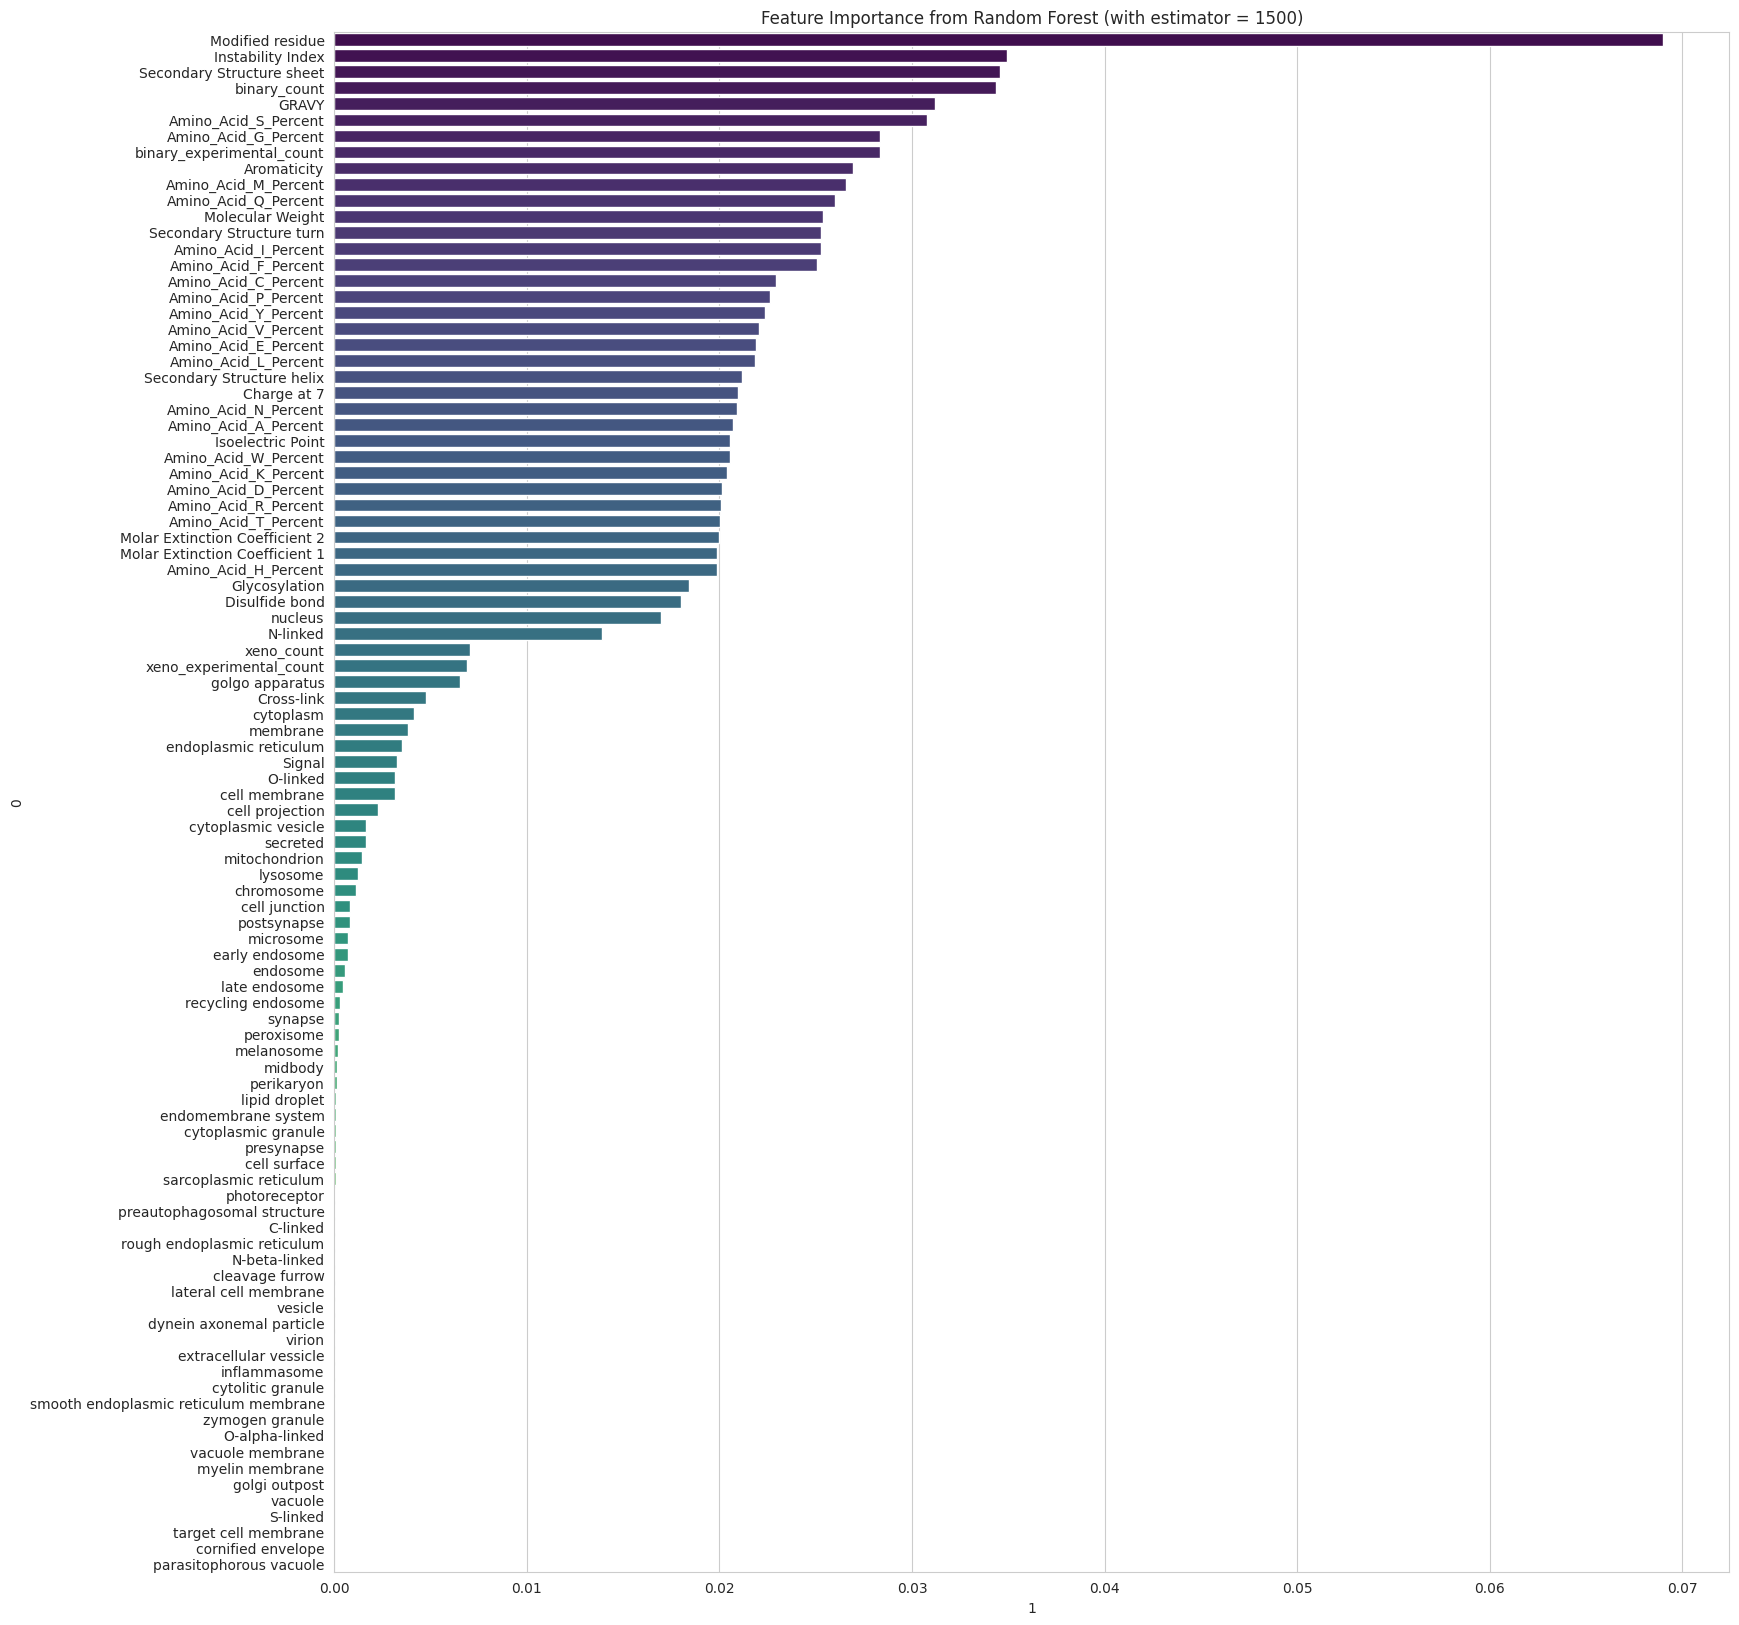

In [ ]:
feature_importance = model_6.feature_importances_
okk = pd.DataFrame([x_sample.columns, feature_importance]).T
okk = okk.sort_values(by = 1,ascending = False)
plt.figure(figsize=(18, 20))
sns.barplot(x = okk[1], y = okk[0], data = okk, palette='viridis')
plt.title("Feature Importance from Random Forest (with estimator = 1500)")
plt.show()

cell surface                0.000000
dynein axonemal particle    0.000000
golgi outpost               0.000000
vacuole membrane            0.000000
lateral cell membrane       0.000000
                              ...   
golgo apparatus             0.031051
Disulfide bond              0.032734
cell membrane               0.041461
microsome                   0.044030
Modified residue            0.053035
Length: 96, dtype: float32


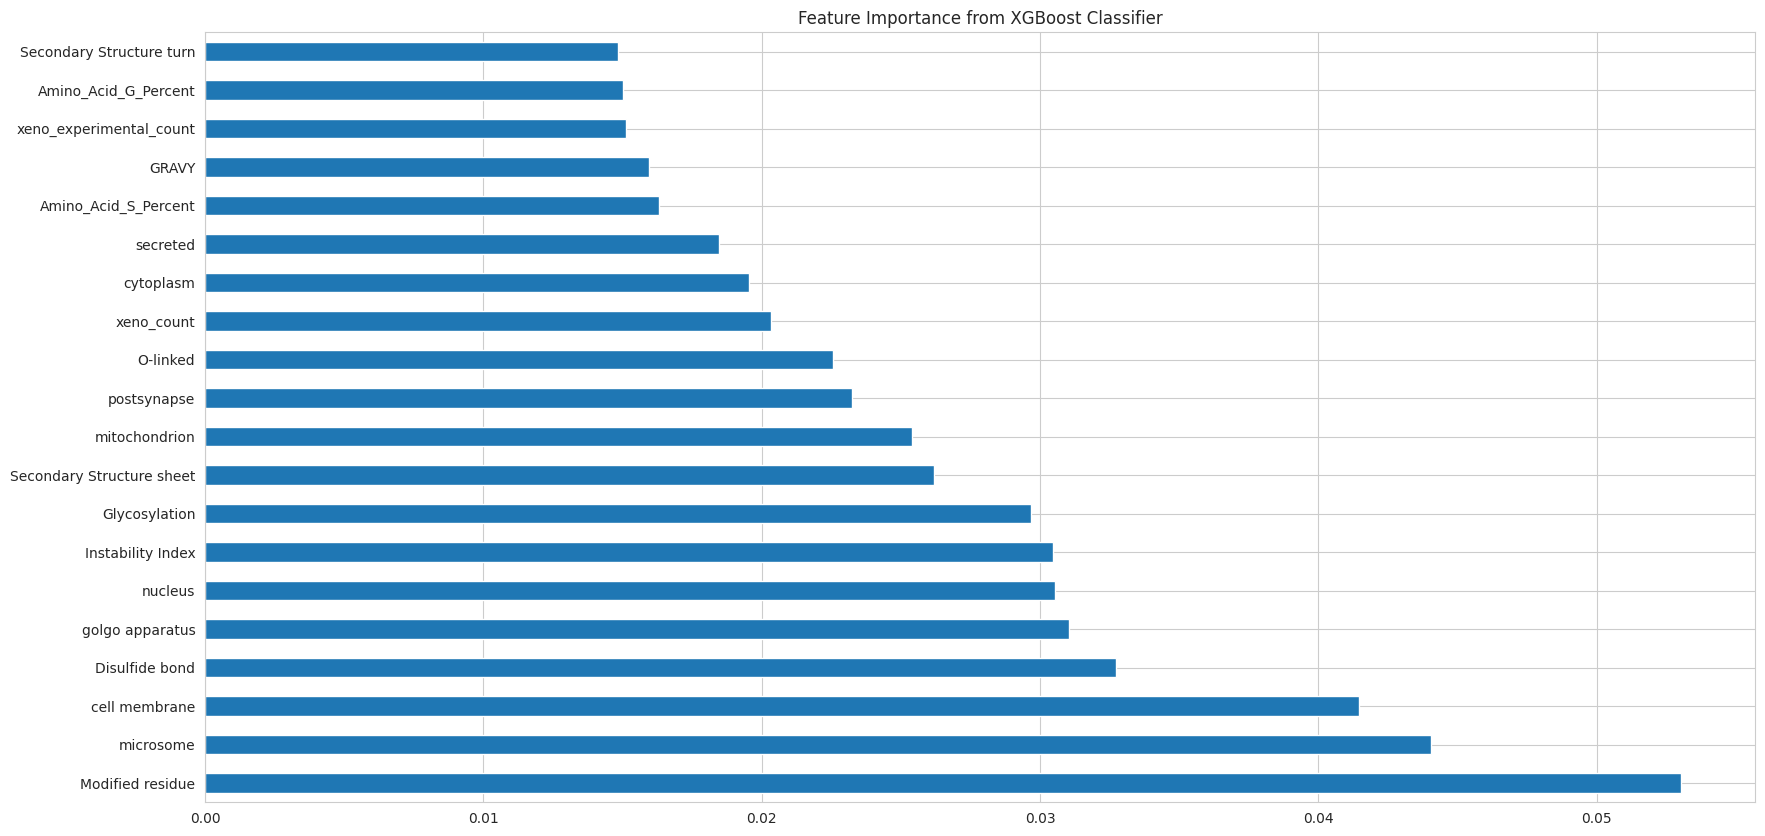

In [ ]:
feat_imp = pd.Series(model.feature_importances_, index=x_sample.columns)
print(feat_imp.sort_values())
feat_imp.nlargest(20).plot(kind='barh',figsize=(20,10))
plt.title('Feature Importance from XGBoost Classifier')
plt.show()

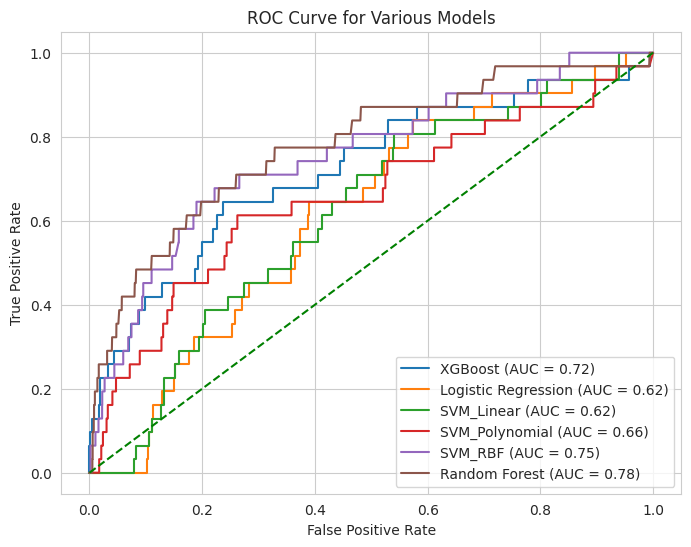

In [ ]:
#roc-auc curve for various algorithm
fpr_1, tpr_1, _ = roc_curve(y_test, model_1.predict_proba(X_test)[:, 1])
fpr_2, tpr_2, _ = roc_curve(y_test, model_2.predict_proba(X_test)[:, 1])
fpr_3, tpr_3, _ = roc_curve(y_test, model_3.predict_proba(X_test)[:, 1])
fpr_4, tpr_4, _ = roc_curve(y_test, model_4.predict_proba(X_test)[:, 1])
fpr_5, tpr_5, _ = roc_curve(y_test, model_5.predict_proba(X_test)[:, 1])
fpr_6, tpr_6, _ = roc_curve(y_test, model_6.predict_proba(X_test)[:, 1])

from sklearn.metrics import roc_auc_score

auc_1 = roc_auc_score(y_test, model_1.predict_proba(X_test)[:, 1])
auc_2 = roc_auc_score(y_test, model_2.predict_proba(X_test)[:, 1])
auc_3 = roc_auc_score(y_test, model_3.predict_proba(X_test)[:, 1])
auc_4 = roc_auc_score(y_test, model_4.predict_proba(X_test)[:, 1])
auc_5 = roc_auc_score(y_test, model_5.predict_proba(X_test)[:, 1])
auc_6 = roc_auc_score(y_test, model_6.predict_proba(X_test)[:, 1])

# Plot ROC curves for each model with AUC values in the legend
plt.figure(figsize=(8, 6))
plt.plot(fpr_1, tpr_1, label=f'XGBoost (AUC = {auc_1:.2f})')
plt.plot(fpr_2, tpr_2, label=f'Logistic Regression (AUC = {auc_2:.2f})')
plt.plot(fpr_3, tpr_3, label=f'SVM_Linear (AUC = {auc_3:.2f})')
plt.plot(fpr_4, tpr_4, label=f'SVM_Polynomial (AUC = {auc_4:.2f})')
plt.plot(fpr_5, tpr_5, label=f'SVM_RBF (AUC = {auc_5:.2f})')
plt.plot(fpr_6, tpr_6, label=f'Random Forest (AUC = {auc_6:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='green', linestyle='--')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Various Models')
plt.legend()
plt.show()